In [1]:
import pandas as pd
import seaborn as sns
import xgboost as xgb

from sqlalchemy import create_engine
from datetime import datetime
from datetime import timedelta
from matplotlib import pyplot as plt
from sklearn import model_selection

# scikit-learn             1.0.2
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import BayesianRidge, LinearRegression, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score


In [2]:
engine  = create_engine("mysql+pymysql://{}:{}@{}:{}/{}".format('root', '123456', 'localhost', '3306', 'erp_jd_dwd'))  
engine  = create_engine("mysql+pymysql://{}:{}@{}:{}/{}".format('root', '123456', 'localhost', '3306', 'erp_jd_dwd'))  
engine1 = create_engine("mysql+pymysql://{}:{}@{}:{}/{}".format('root', '123456', 'localhost', '3306', 'bi'))
conn = create_engine("mssql+pymssql://{}:{}@{}:{}/{}".format('sa', '123456', '10.242.21.1', '1433', 'bi'))

df_sales = pd.read_sql_query('select * from erp_jd_dwd_dim_saleshipping;', engine)
api_erp_client  = pd.read_sql_query('select * from erp_jd_dwd_fact_client;',  engine)

In [4]:
df_holiday = pd.read_excel(r'C:\Users\liujin02\Desktop\BI建设\API_BI\本地数据源\vacation.xlsx')

df_holiday['date'] = pd.to_datetime(df_holiday['date'],format='%Y-%m-%d')

df_pro = pd.read_excel(r'C:\Users\liujin02\Desktop\BI建设\API_BI\forecast_sales\产品名称.xlsx')

listPro = df_pro['产品名称'].to_list()
df_sales = df_sales[~df_sales['wuliaomc'].isin(listPro)]

In [5]:
# 将存在其它字符表示分类的特征转化为数字
def dict_(df,name):

    df_wl = df[name].drop_duplicates().reset_index(drop=True)
    df_wl1 = df_wl.reset_index(drop=True).reset_index()
    
    return dict(zip(df_wl1[name],df_wl1['index'])), df_wl



# 创建日期辅助表
def create_assist_date(datestart,dateend):
    date_list = []
    date_list.append(datestart)
    while datestart < dateend:
        datestart+=timedelta(days=+1)
        date_list.append(datestart)
    return pd.DataFrame(date_list,columns=['riqi'])



def change(df2):
    #将时间特征进行拆分和转化
    df2['year']=df2['riqi'].apply(lambda x:x.year)

    df2['weekday'] = df2.apply(lambda x: datetime.weekday(x['riqi'])+1,axis=1)
    # 'weekday' ： 返回中国式星期

    df2 = pd.merge(df2,df_holiday,left_on=['riqi'],right_on=['date'],how='left')
    df2['status'].fillna(0,inplace=True)
    for i in range(len(df2)):
        if df2['status'][i] == 0 and (df2['weekday'][i]==6 or df2['weekday'][i]==7):
            df2['status'][i] = 1
        elif df2['status'][i] != 0:
            continue
        else:
            df2['status'][i] = 2
    # 'status' ： 1：节假日，2：工作日
    df2.drop(['date'],axis=1,inplace=True)

    return df2



# 补日期函数
def datena(df,name):   

    df = df.reset_index(drop=True)
    date_end = df['riqi'].max()
    
    result = []
    for j in range(len(dict_(df,name)[1])):
        df1 = df[df[name]==dict_(df,name)[1][j]]
        date_start = df1['riqi'].min()
        df_date = create_assist_date(date_start,date_end)

        df1 = pd.merge(df_date,df1,on=['riqi'],how='left')
        df1[name].fillna(dict_(df,name)[1][j],inplace=True)
        result.append(df1)
    df2 = pd.concat(result, sort=False)
    df2 = df2.reset_index(drop=True)
    return change(df2), len(df_date)


def getDictKey(mydict,value,word):
    try:
        return [k for k,v in mydict.items() if value == v][0]
    except:
        return word

数据预处理

In [6]:
df_sales['weeknum'] = df_sales['riqi'].map(lambda x: int(datetime.strptime(str(x)[:10],'%Y-%m-%d').strftime('%W'))+1)
df = df_sales.groupby(['riqi','wuliaofzmc']).agg({'shifasl':'sum','jiashuihj':'sum','kehuid':'count'})
df.reset_index(inplace=True)

df1 = df_sales.groupby(['year','weeknum','wuliaofzmc']).agg({'wuliaomc':'unique','name_prov1':'unique'})
df1.reset_index(inplace=True)

df_qd = datena(df,'wuliaofzmc')[0]

df_qd['status_vaca'] = df_qd['status'].map(lambda x:1 if x == 1 else 0)
df_qd['status_work'] = df_qd['status'].map(lambda x:1 if x == 2 else 0)
df_qd['weeknum'] = df_qd['riqi'].map(lambda x: int(datetime.strptime(str(x)[:10],'%Y-%m-%d').strftime('%W'))+1)
df_qd['vacation'] = df_qd['weeknum'].map(lambda x:1 if x in [1,2,3,4,5,6,7,8,27,28,29,30,31,32,33,34,35] else 0)# 1为寒暑假，0为非寒暑假

df1['wuliaomc'] = df1['wuliaomc'].map(lambda x:len(x))
df1['name_prov1'] = df1['name_prov1'].map(lambda x:len(x))
df1['year'] = df1['year'].astype(int)

table = df_qd.groupby(['wuliaofzmc','year','weeknum']).agg({'shifasl':'sum','jiashuihj':'sum','kehuid':'sum','status_work':'sum','status_vaca':'sum'})#
table.reset_index(inplace=True)
table['price'] = table['jiashuihj']/table['shifasl']
table = table.drop(columns=['jiashuihj'],axis=1).reset_index() 

df_qd = pd.merge(table,df1 ,on = ['wuliaofzmc','year','weeknum'],how='left')
df_qd.fillna(0,inplace=True)

KeyError: "Column(s) ['name_prov1'] do not exist"

分类的特征转化为数字

In [ ]:
dict_wl = dict_(df_qd,'wuliaofzmc')[0]
print(dict_wl)
df_qd['wuliaofzmc'].replace(dict_wl,inplace=True)

{'E系列': 0, 'H1系列': 1, 'H2系列': 2, 'H3系列': 3, 'H5系列': 4, 'H6系列': 5, 'Hello Kitty系列': 6, 'I7': 7, 'IP类': 8, 'K系列': 9, 'LM-其他': 10, 'S1': 11, 'S2': 12, 'S4': 13, 'S6': 14, 'S特': 15, 'X4': 16, 'X6': 17, 'Y1': 18, 'Y3': 19, 'Yokakids代理类': 20, 'Yokakids常规类': 21, 'Yokasmart系列': 22, '三国杀英雄传': 23, '代理类': 24, '便携版': 25, '其他': 26, '其他类': 27, '其他系列': 28, '剧本杀': 29, '剧本杀J1': 30, '半成品': 31, '卡牌周边类': 32, '周边': 33, '天天富翁系列': 34, '定制系列': 35, '常规类': 36, '常规系列': 37, '德文': 38, '手办类': 39, '日文': 40, '明星大侦探系列': 41, '服饰穿戴类': 42, '核心桌游': 43, '火影忍者系列': 44, '生活用品类': 45, '电商剧本杀': 46, '电商核心桌游': 47, '电商益智桌游': 48, '电子3C类': 49, '真相档案系列': 50, '自制剧本杀': 51, '英文': 52, '谋杀之谜': 53, '谋杀之迷': 54}


趋势查看

D:\lib\site-packages\pandas\plotting\_matplotlib\core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


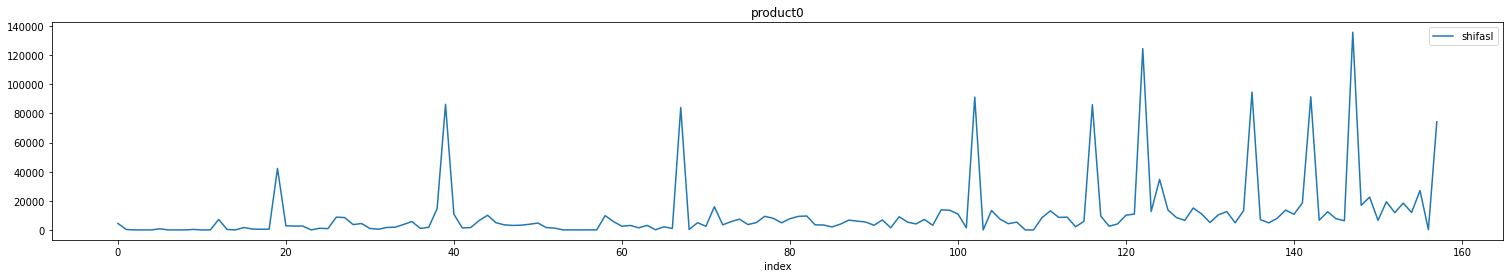

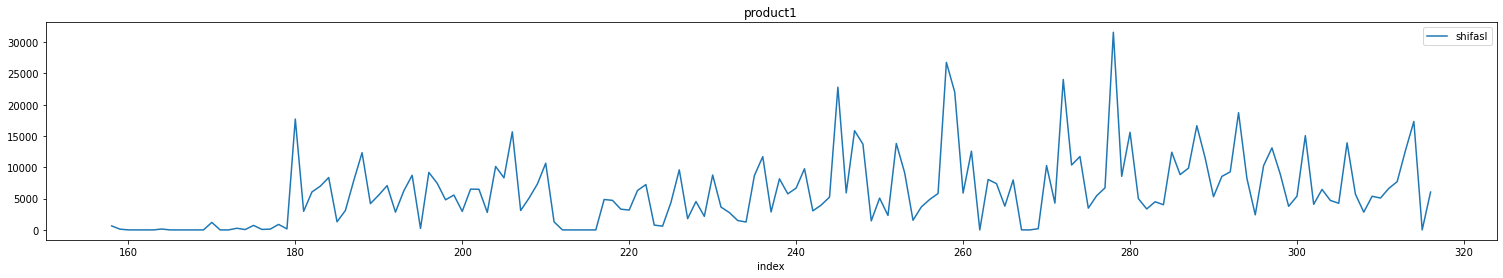

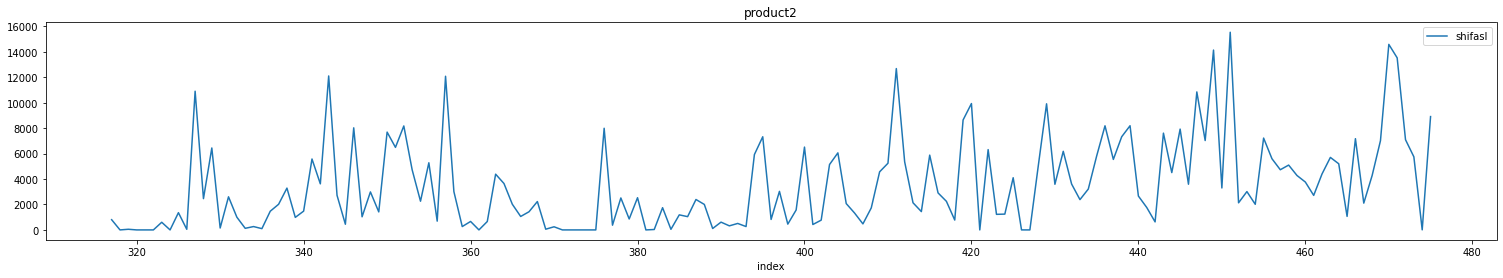

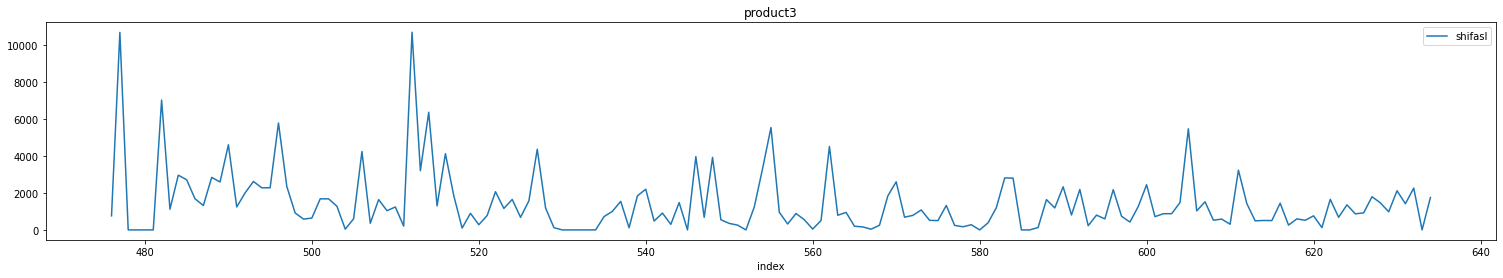

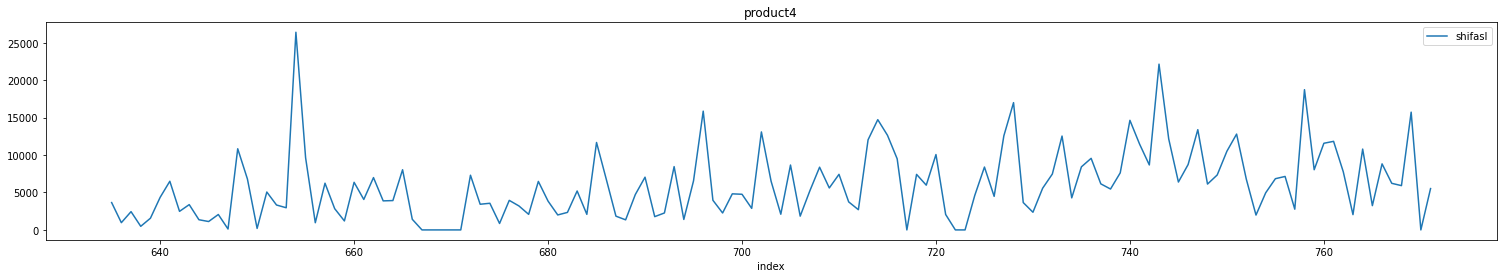

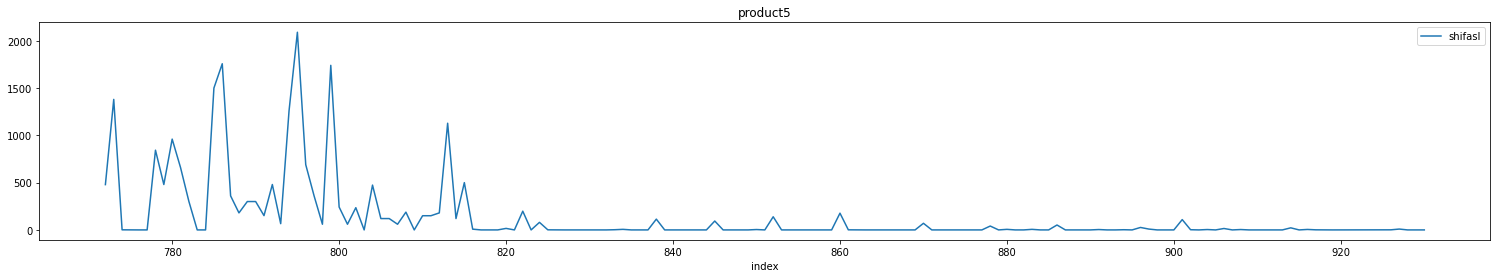

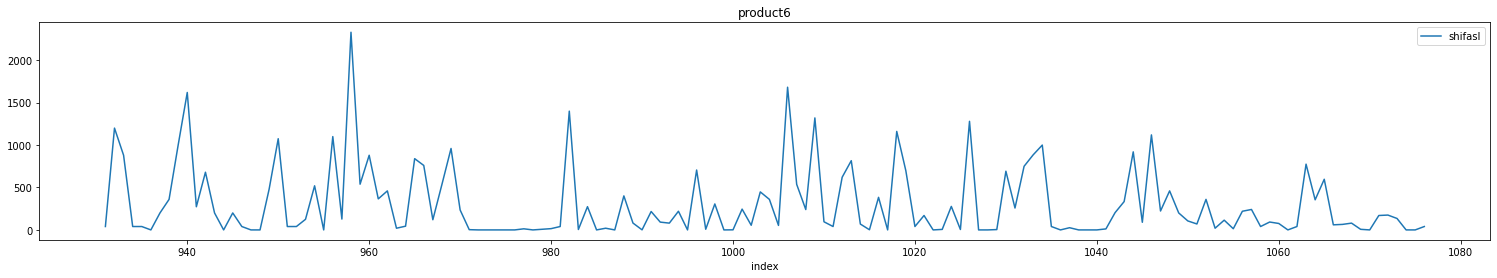

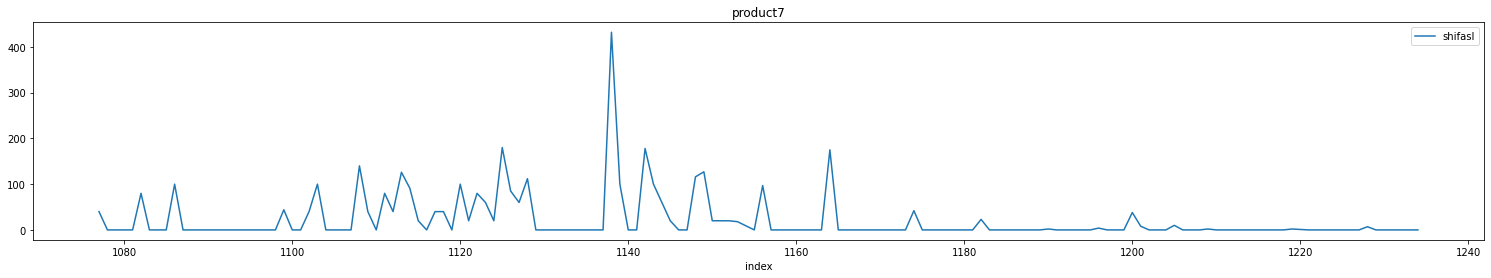

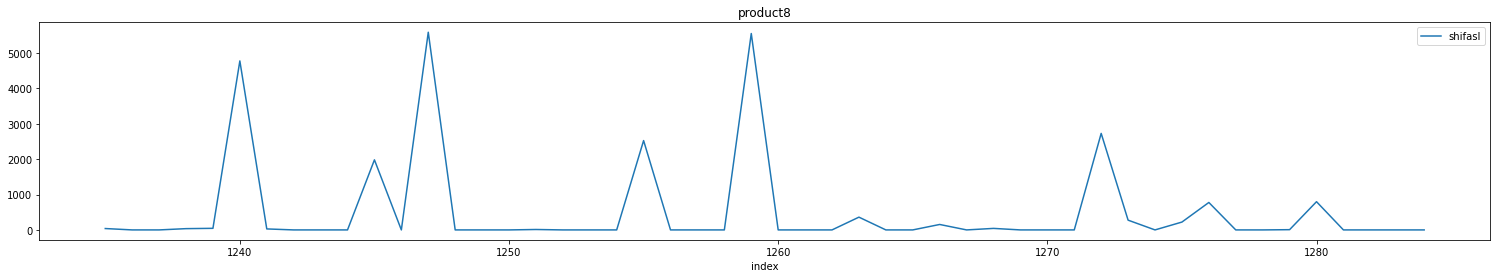

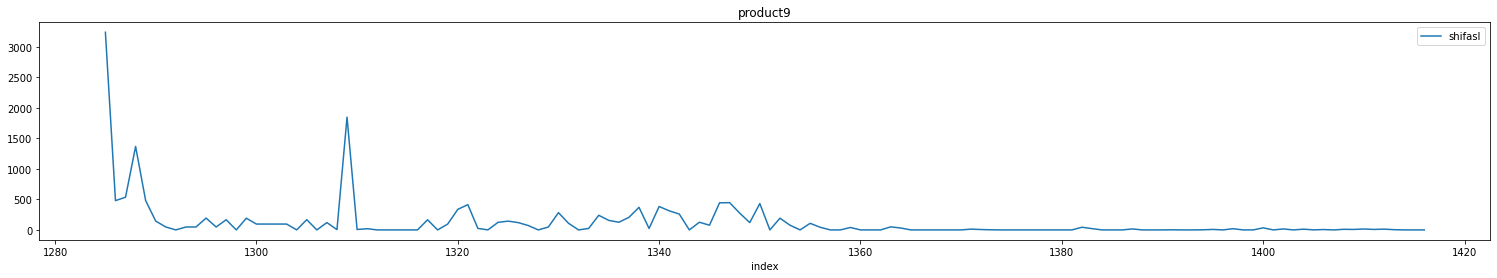

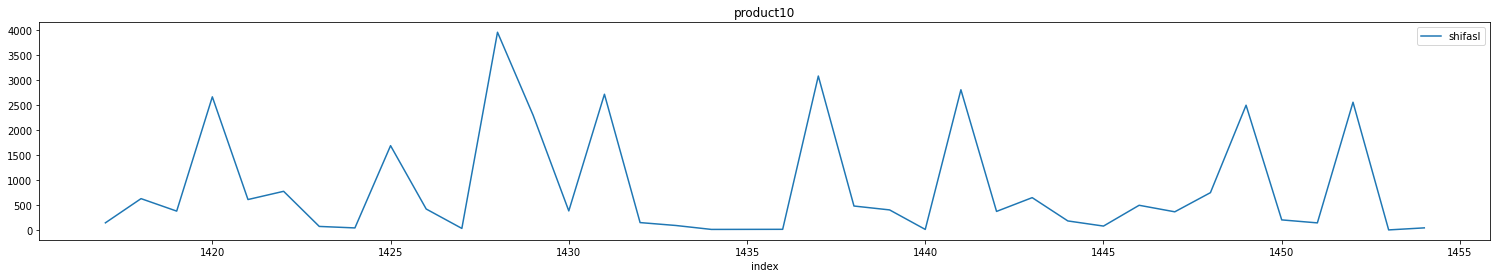

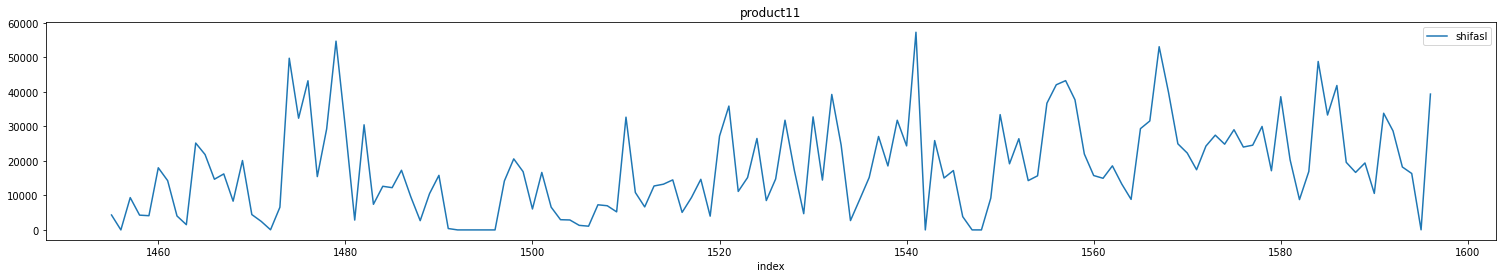

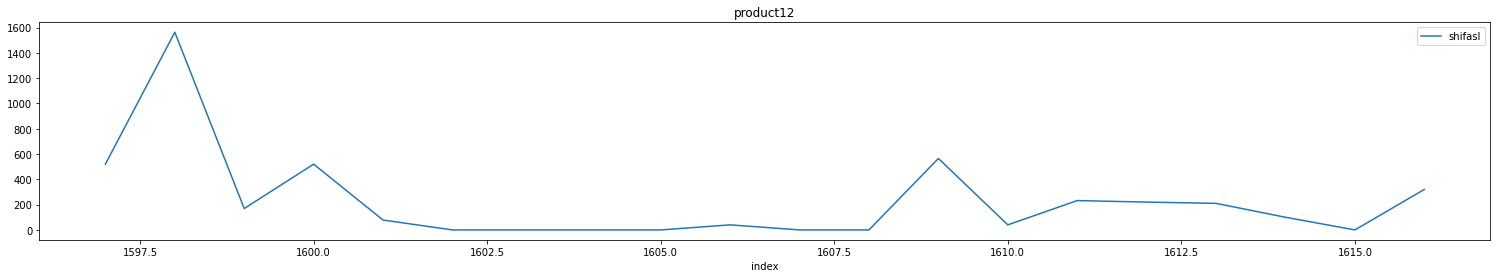

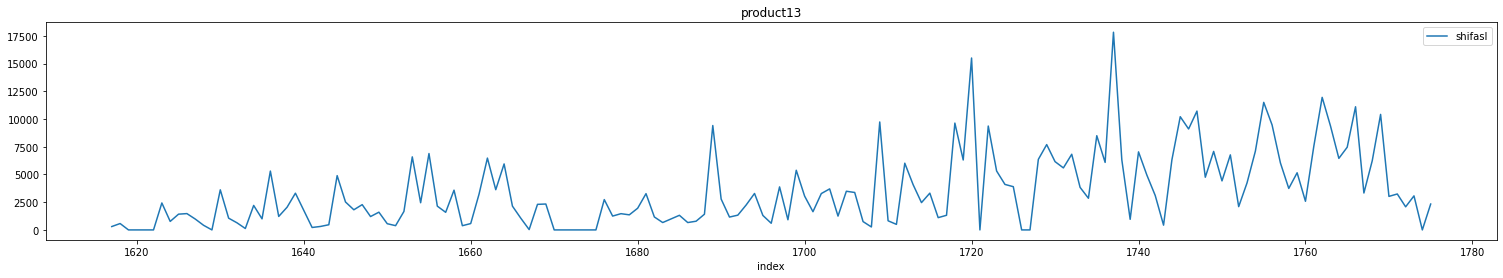

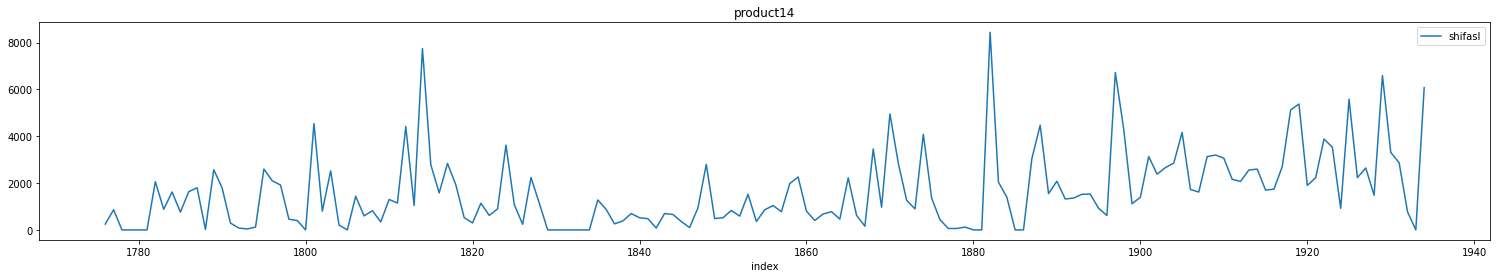

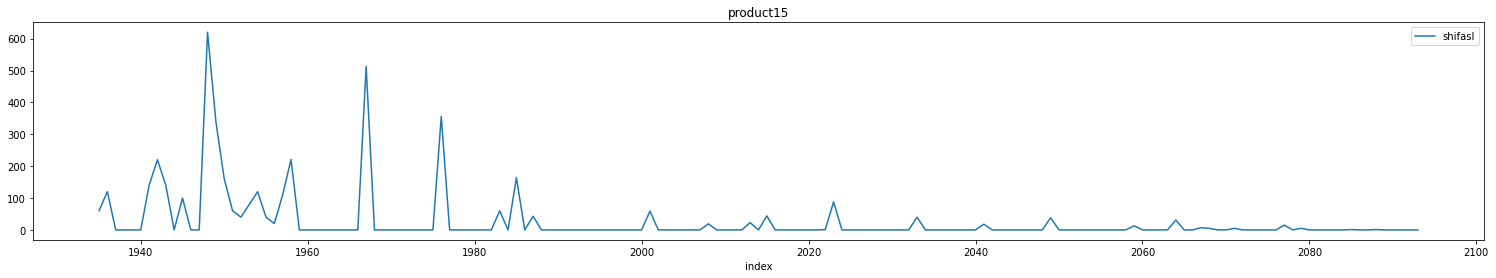

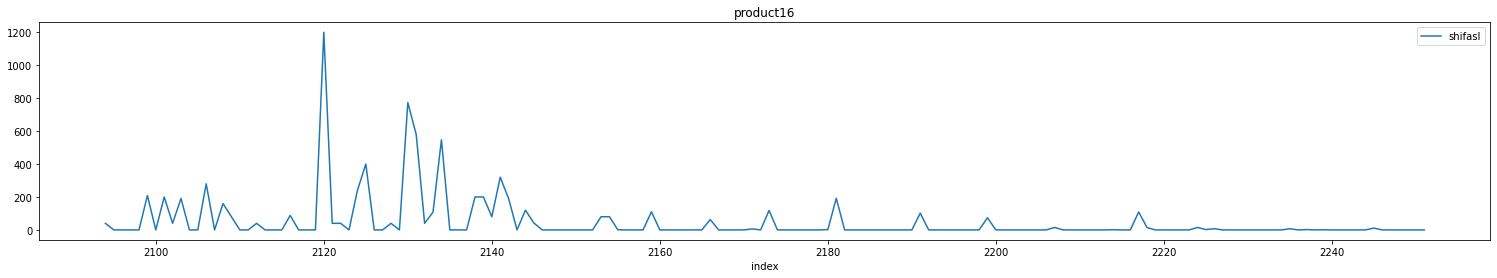

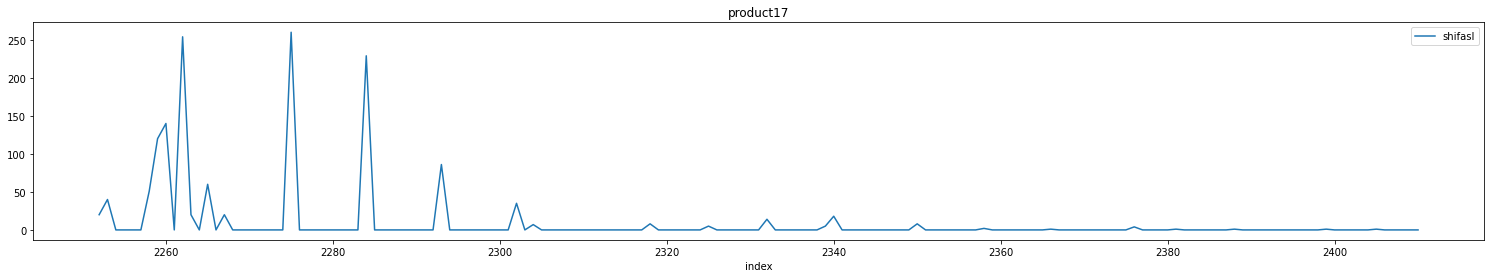

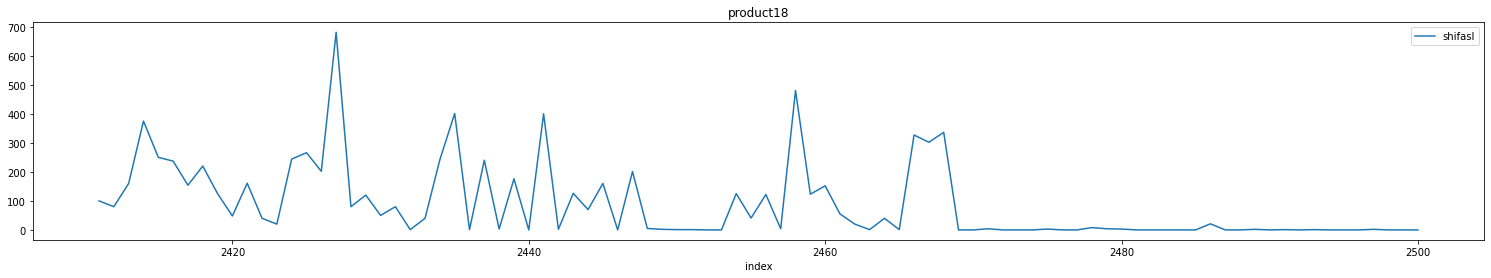

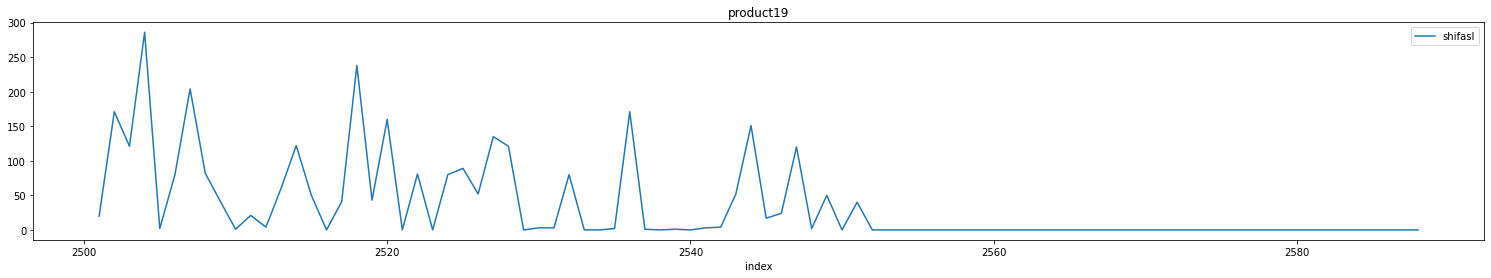

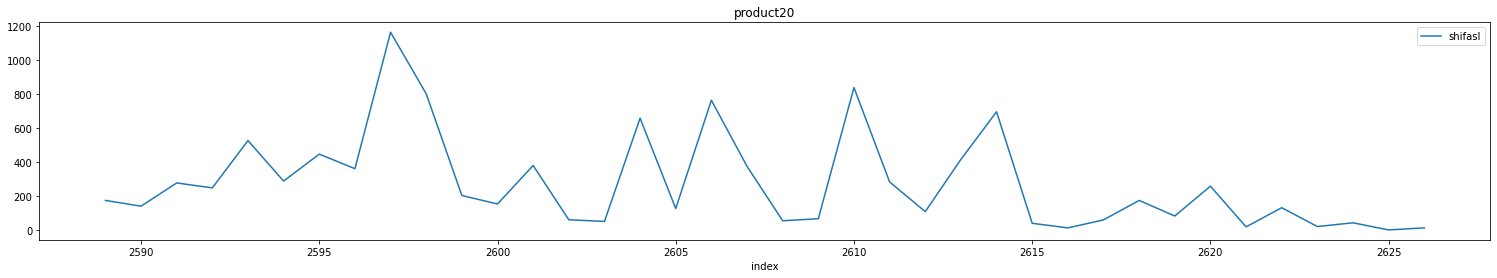

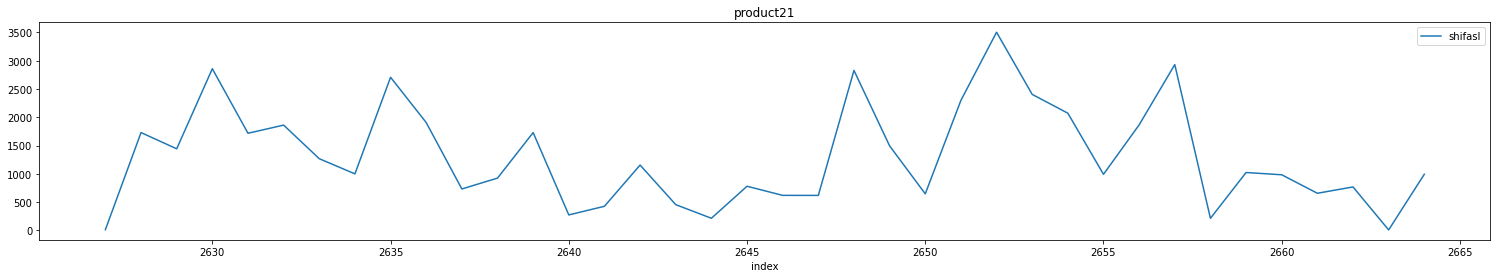

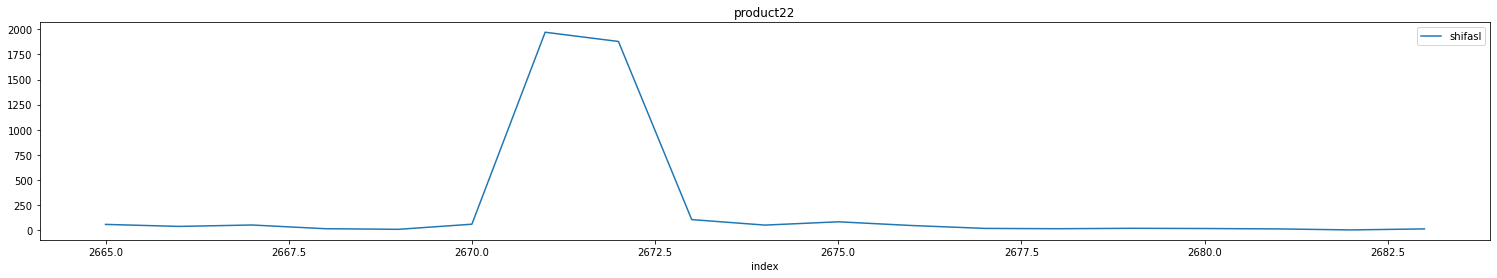

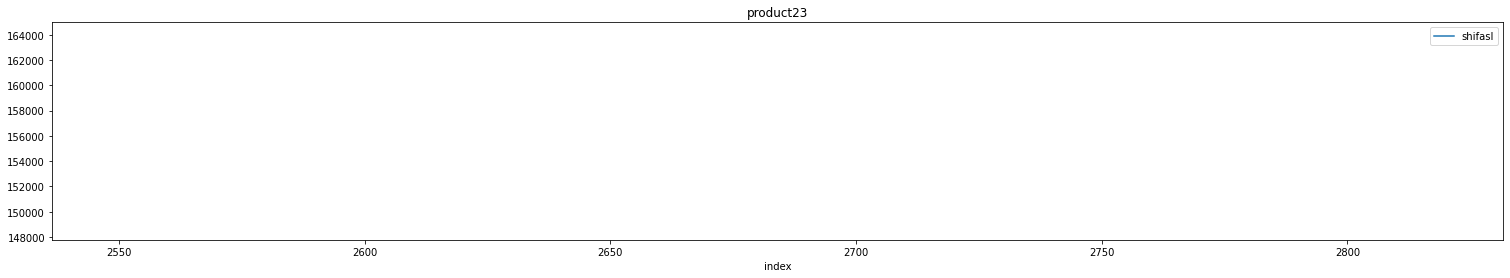

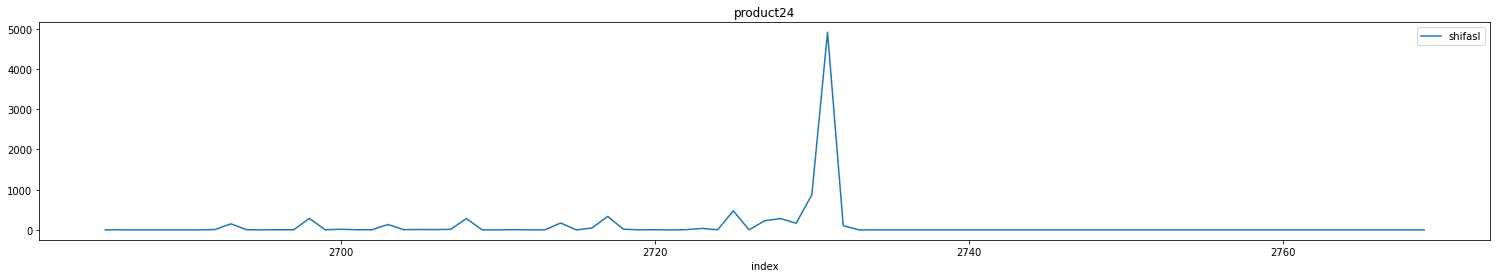

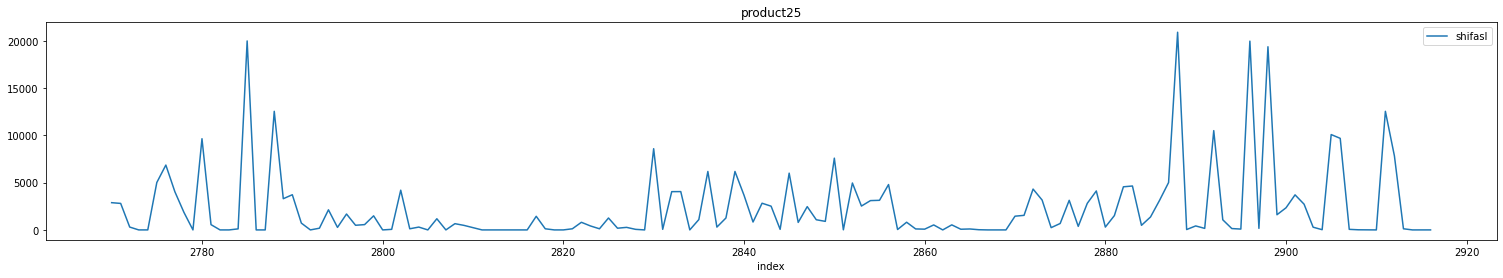

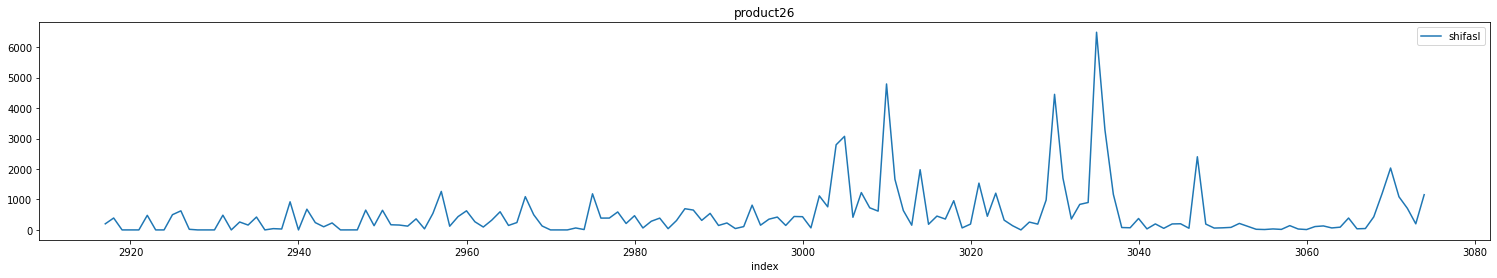

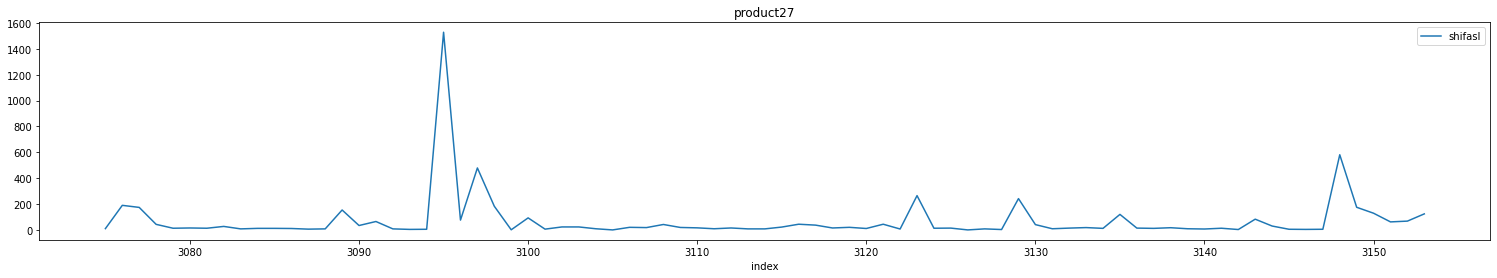

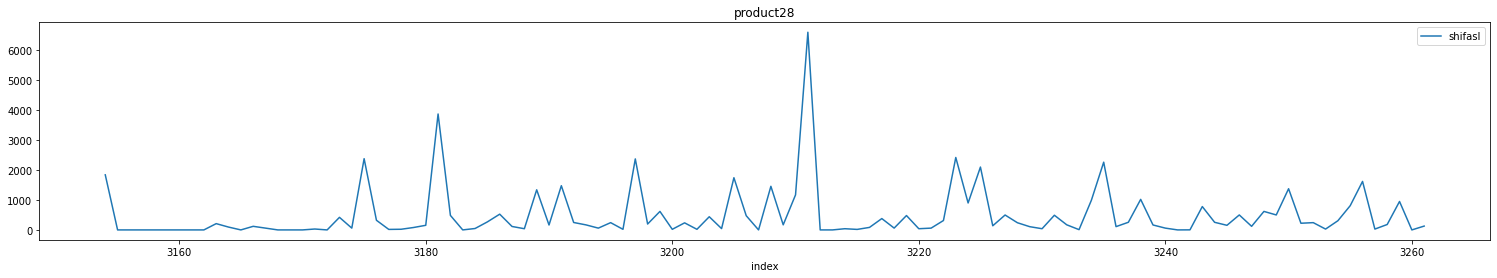

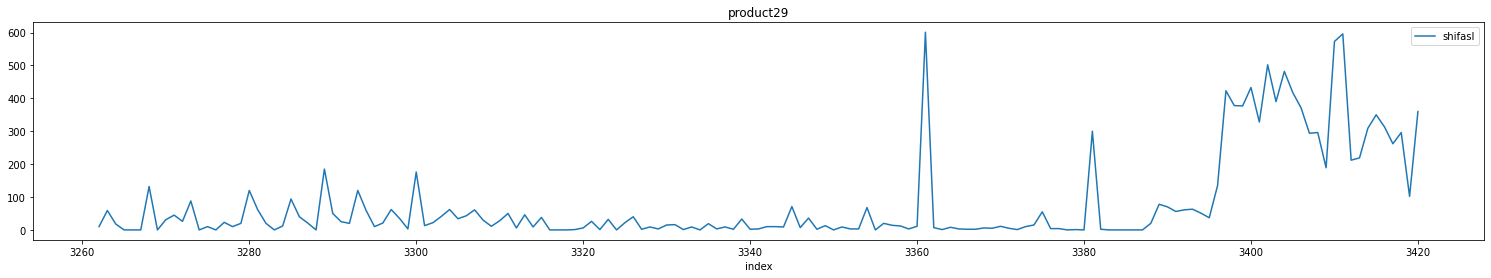

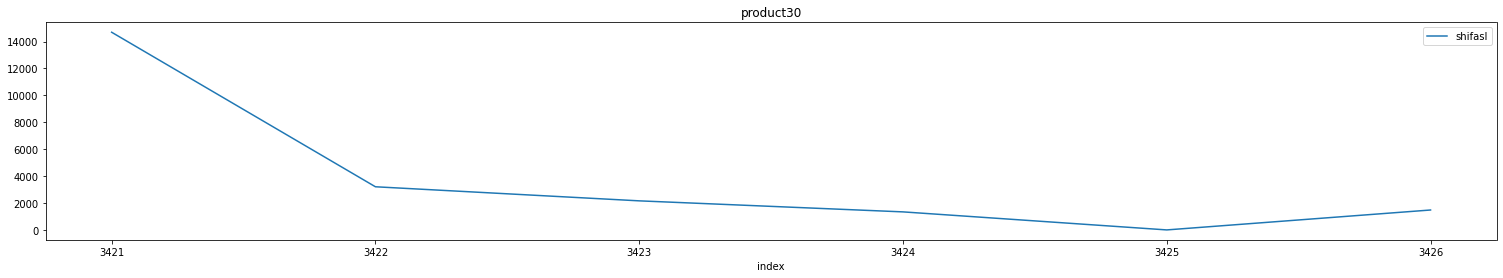

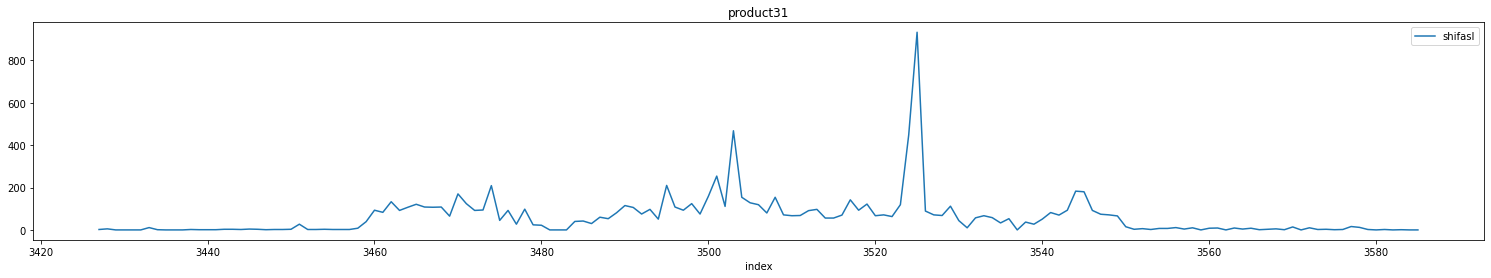

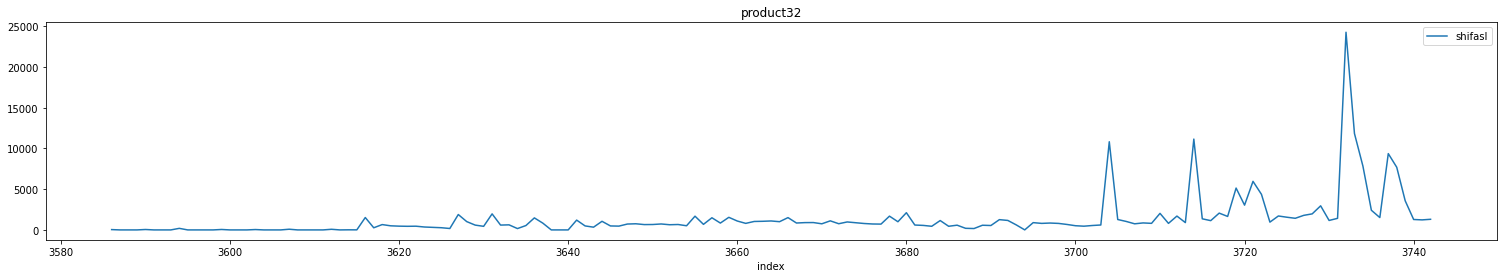

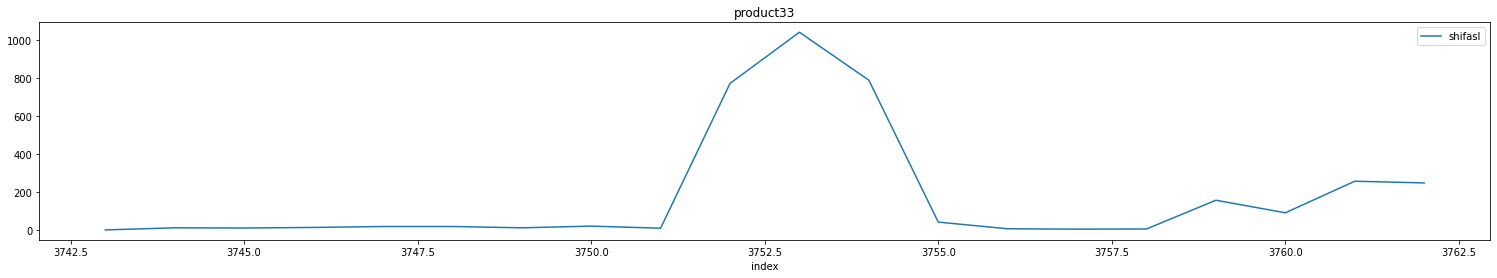

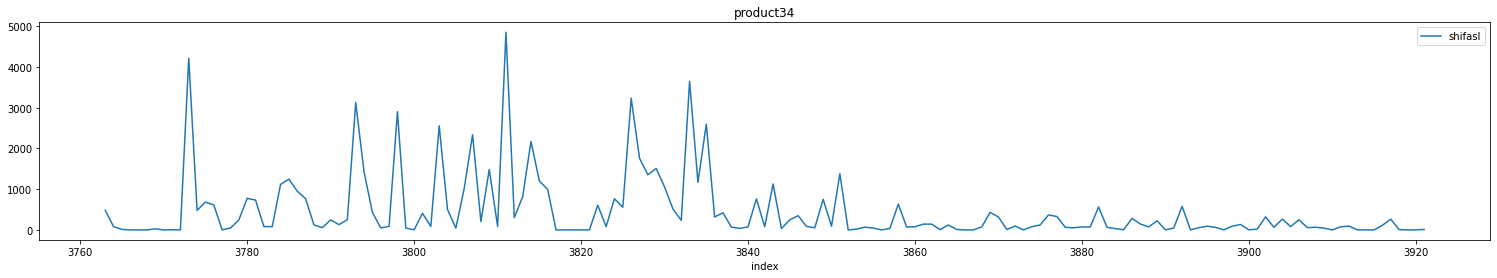

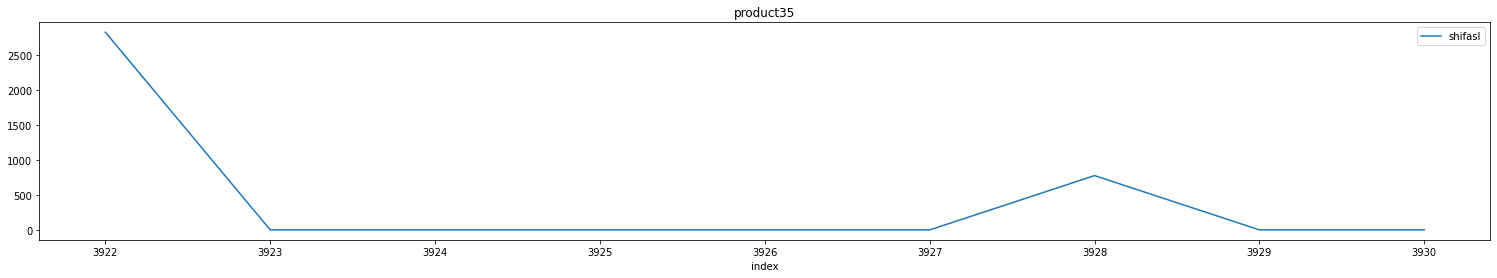

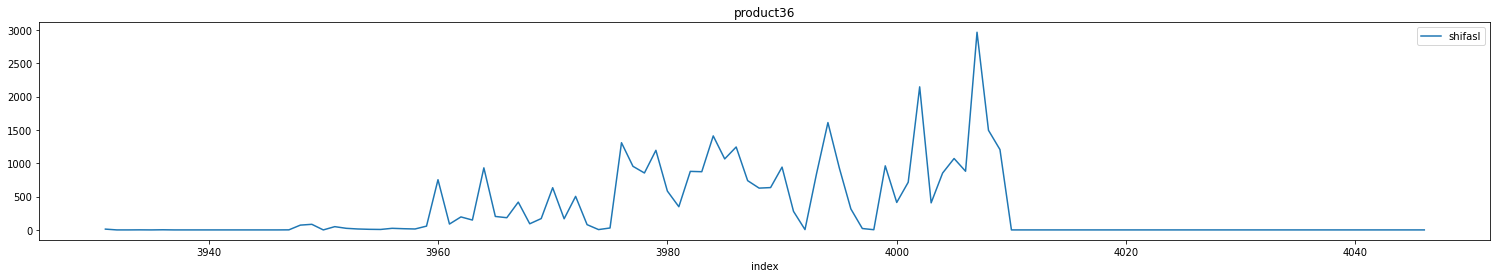

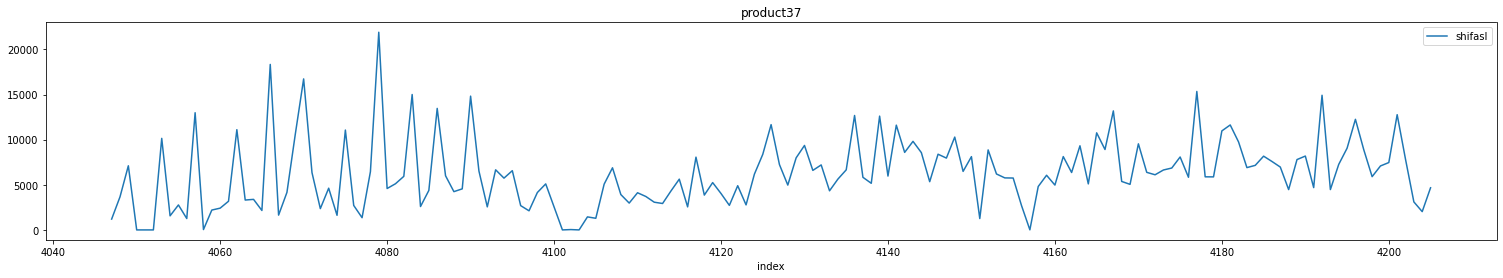

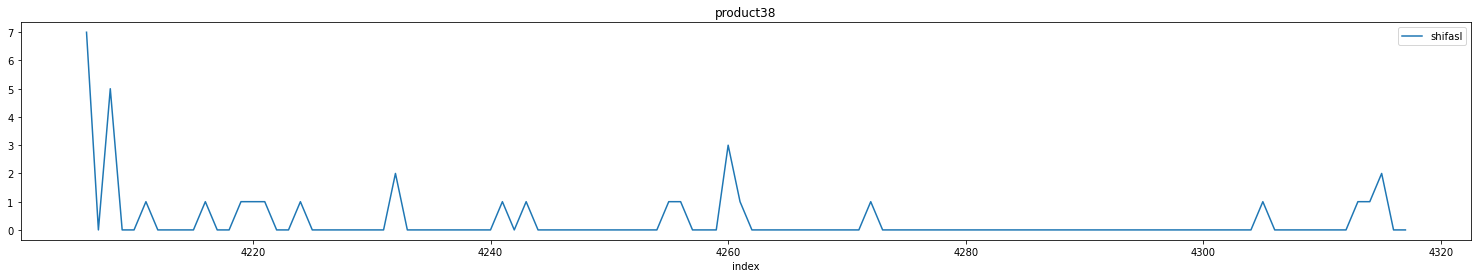

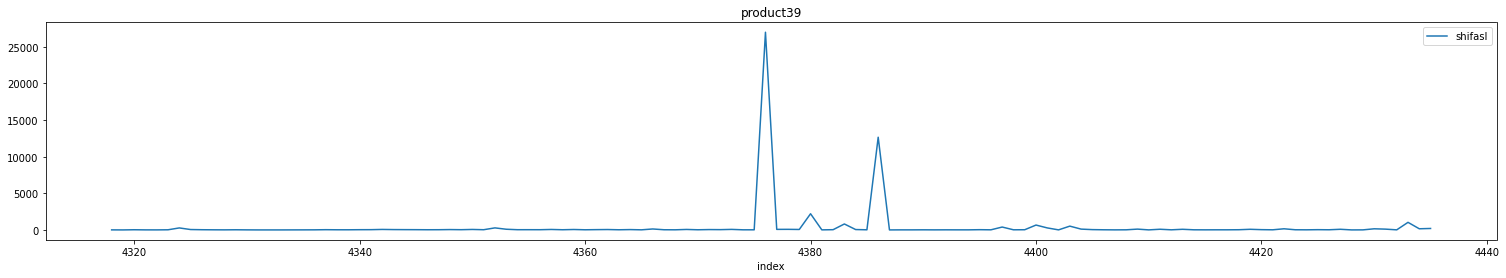

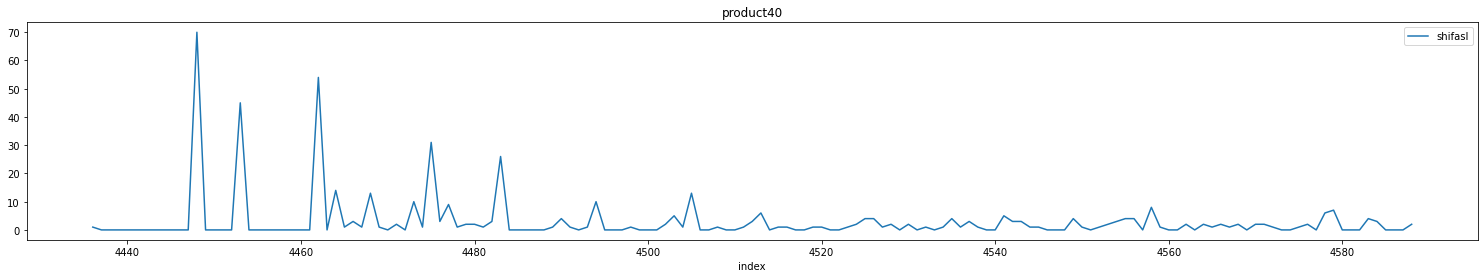

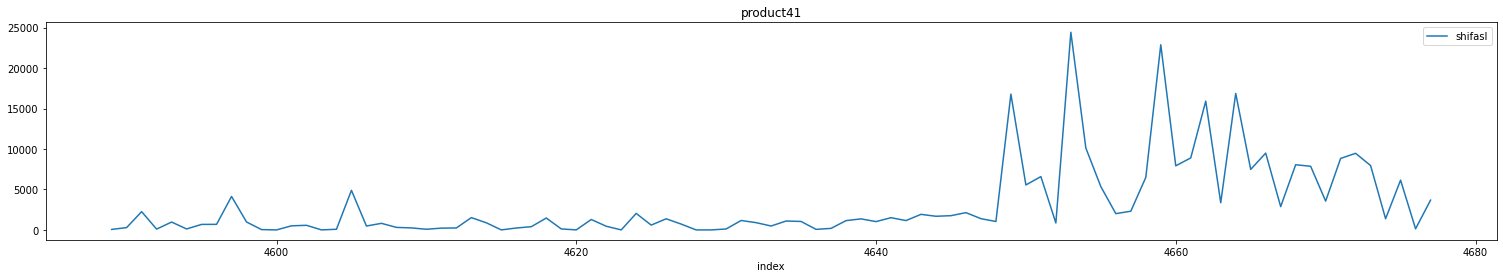

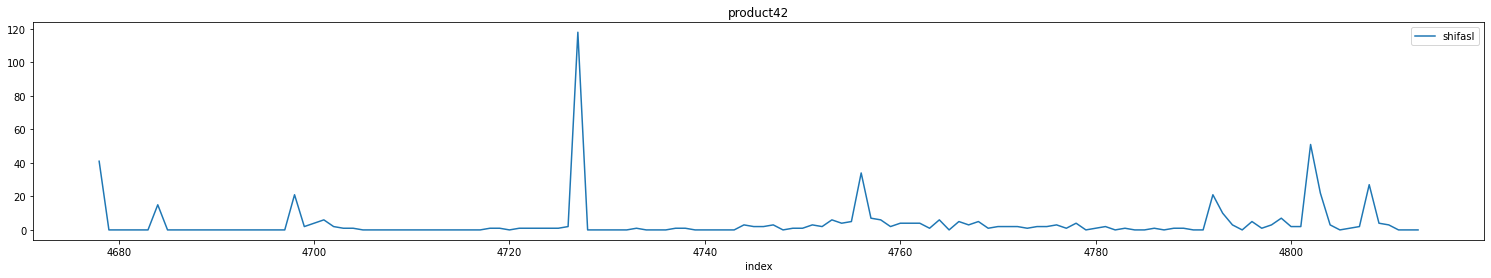

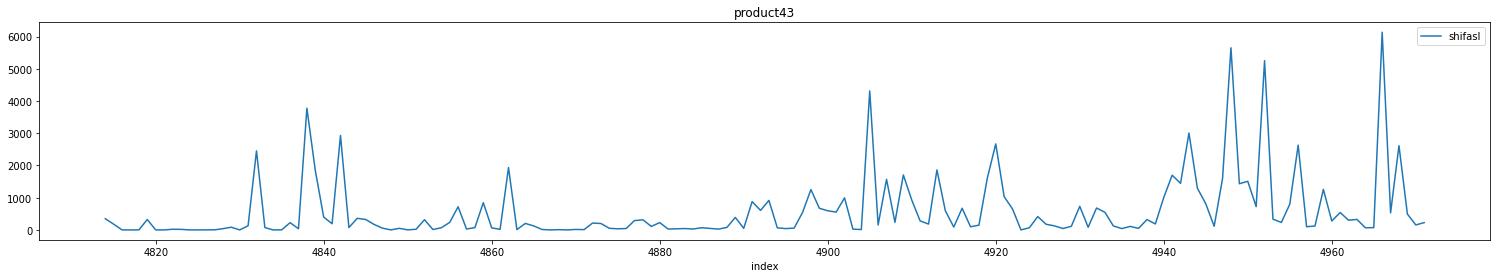

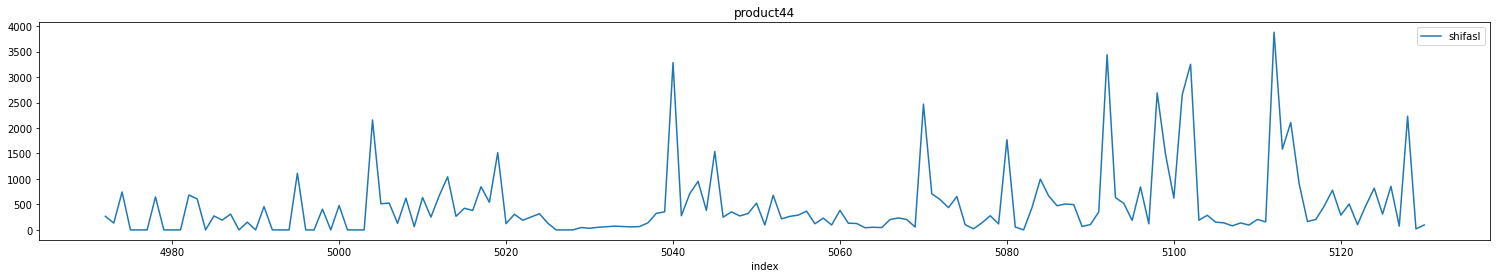

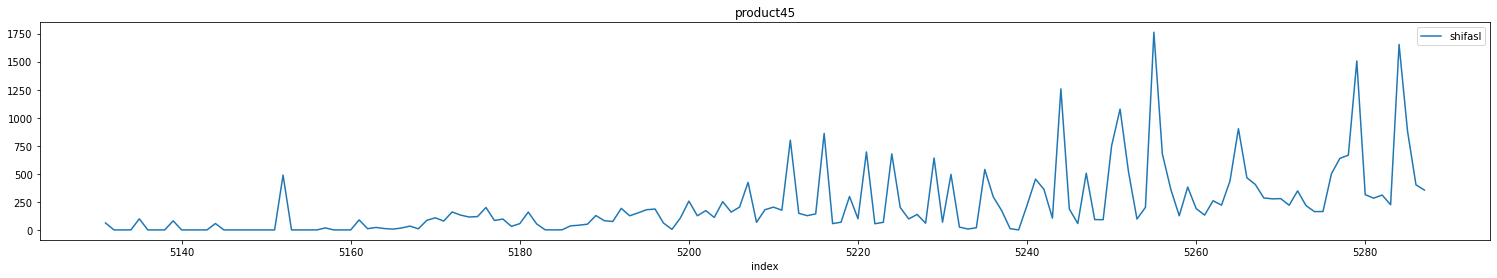

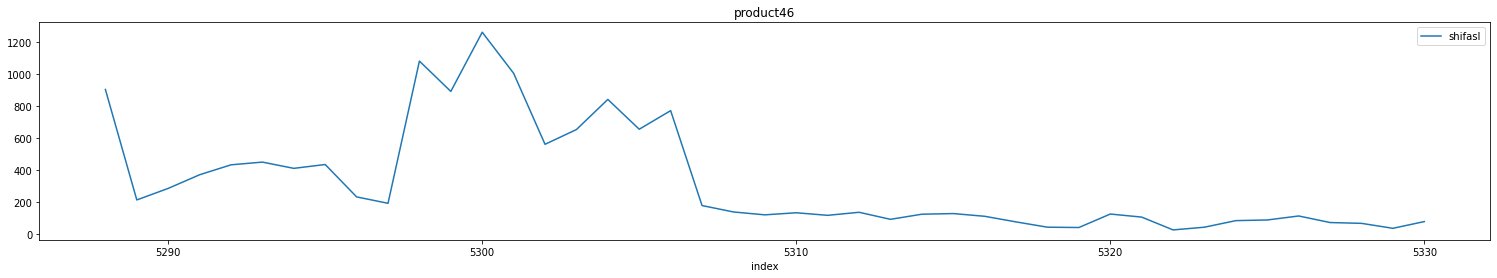

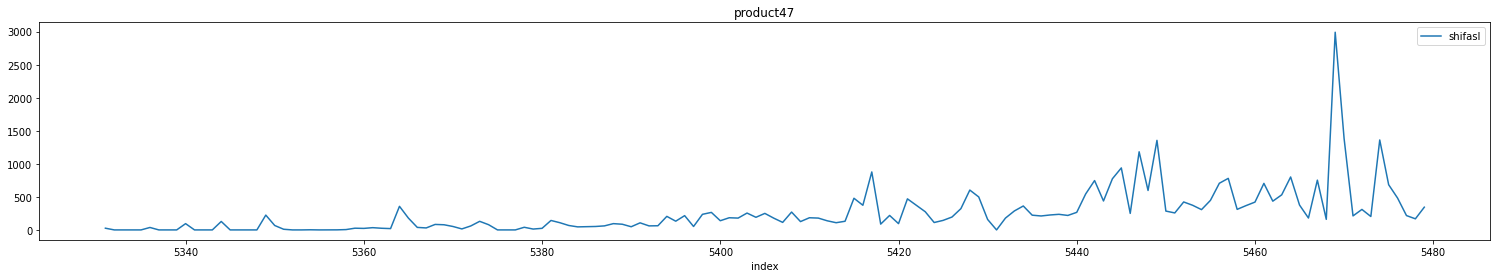

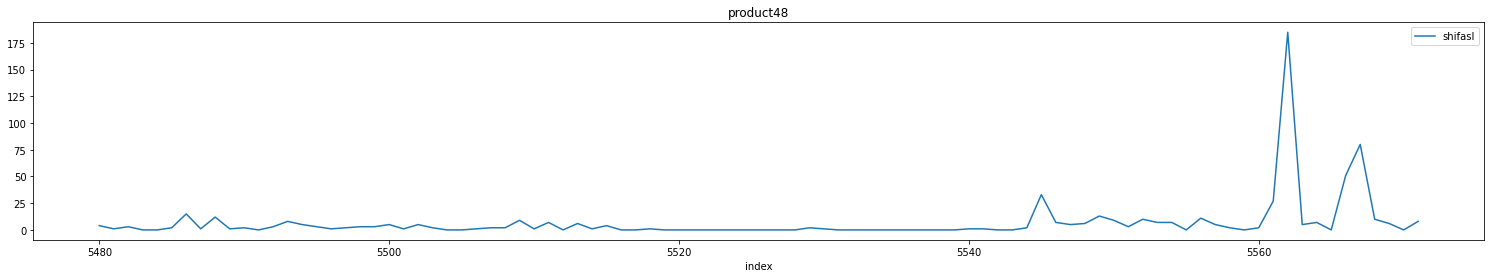

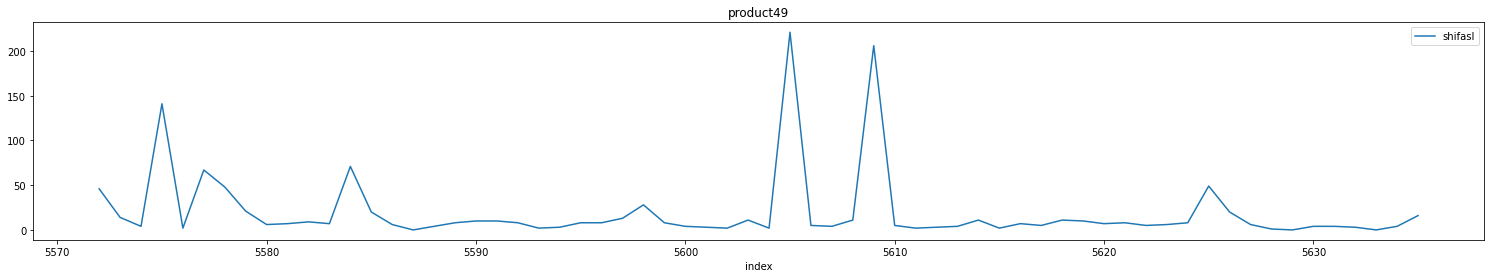

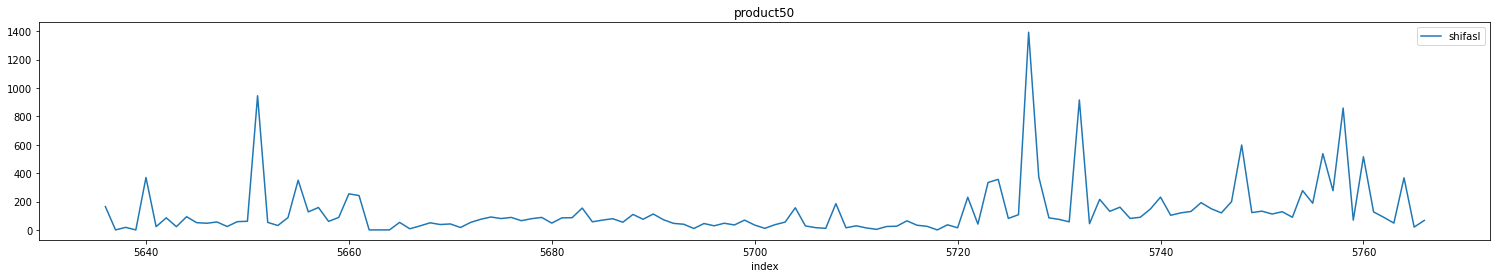

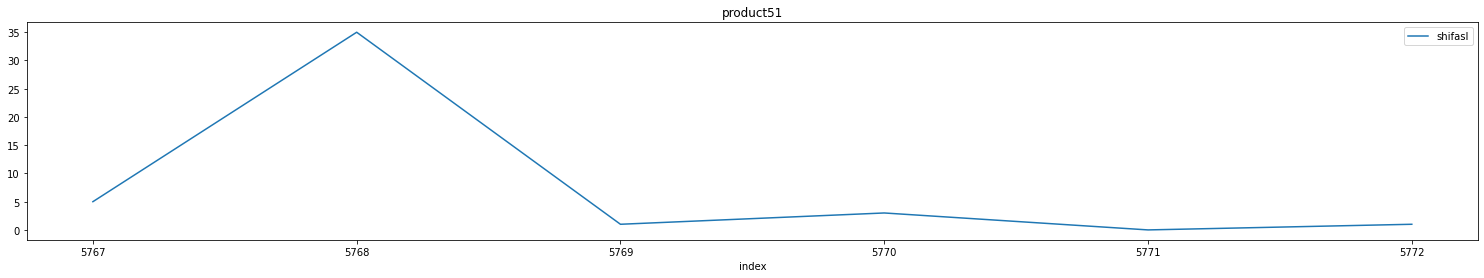

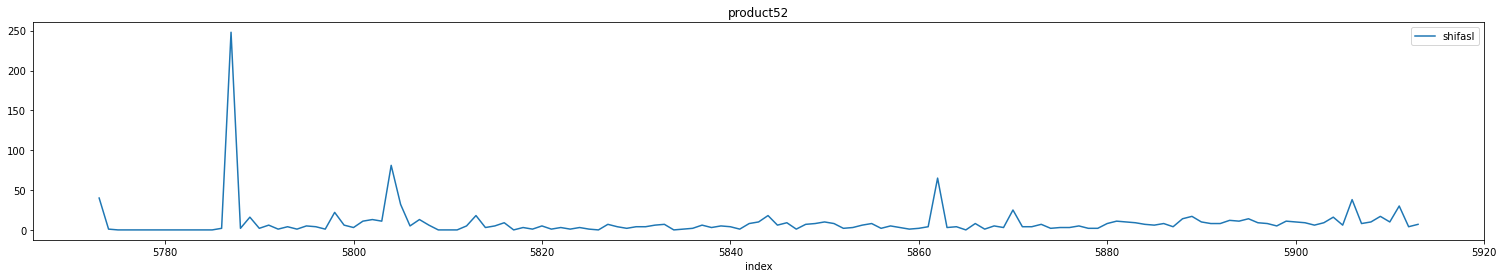

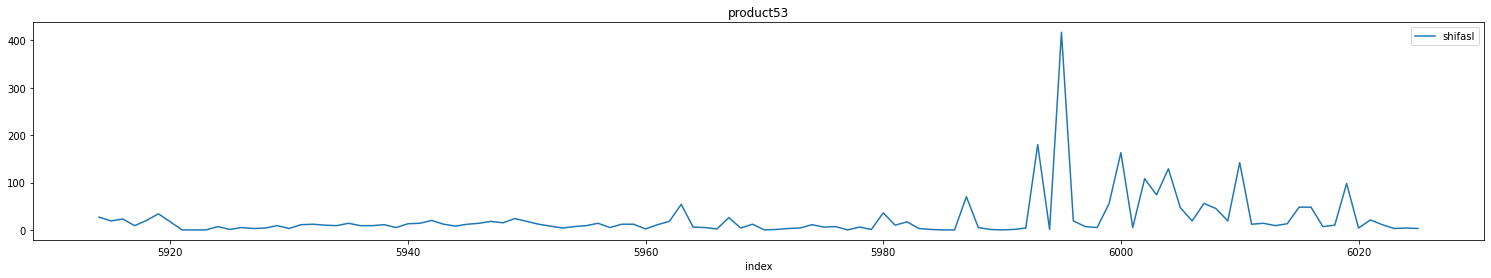

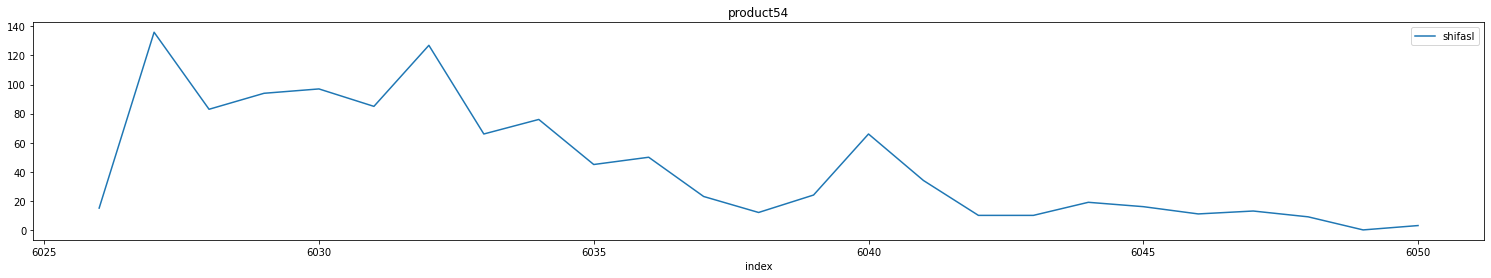

In [ ]:
for i in range(len(dict_wl)):
    df_qd.loc[df_qd['wuliaofzmc']==i,['index','shifasl']].plot(x='index',y='shifasl',title='product'+str(i),figsize=(26,4))

In [ ]:
df_qd['yweek'] = df_qd['year']*100+df_qd['weeknum']
df_qd.sort_values(['yweek','wuliaofzmc'],inplace=True) # 时间升序
df_qd.reset_index(drop=True,inplace=True)
df_qd['shifasl'] = df_qd['shifasl'].replace(0,1) # 由于后续涉及的计算，销量用1填充
df_qd = df_qd.drop(['index'],axis=1).reset_index()

分析训练数据集中特征相关性

保留特征

['year','weeknum','wuliaofzmc','kehuid'（客户数量）,'status_work'（工作日）,'status_vaca'（假期）,

'price','wuliaomc'（sku数量）,'name_prov1'（省份数量）,'vacation'（寒暑假）]

<AxesSubplot:>

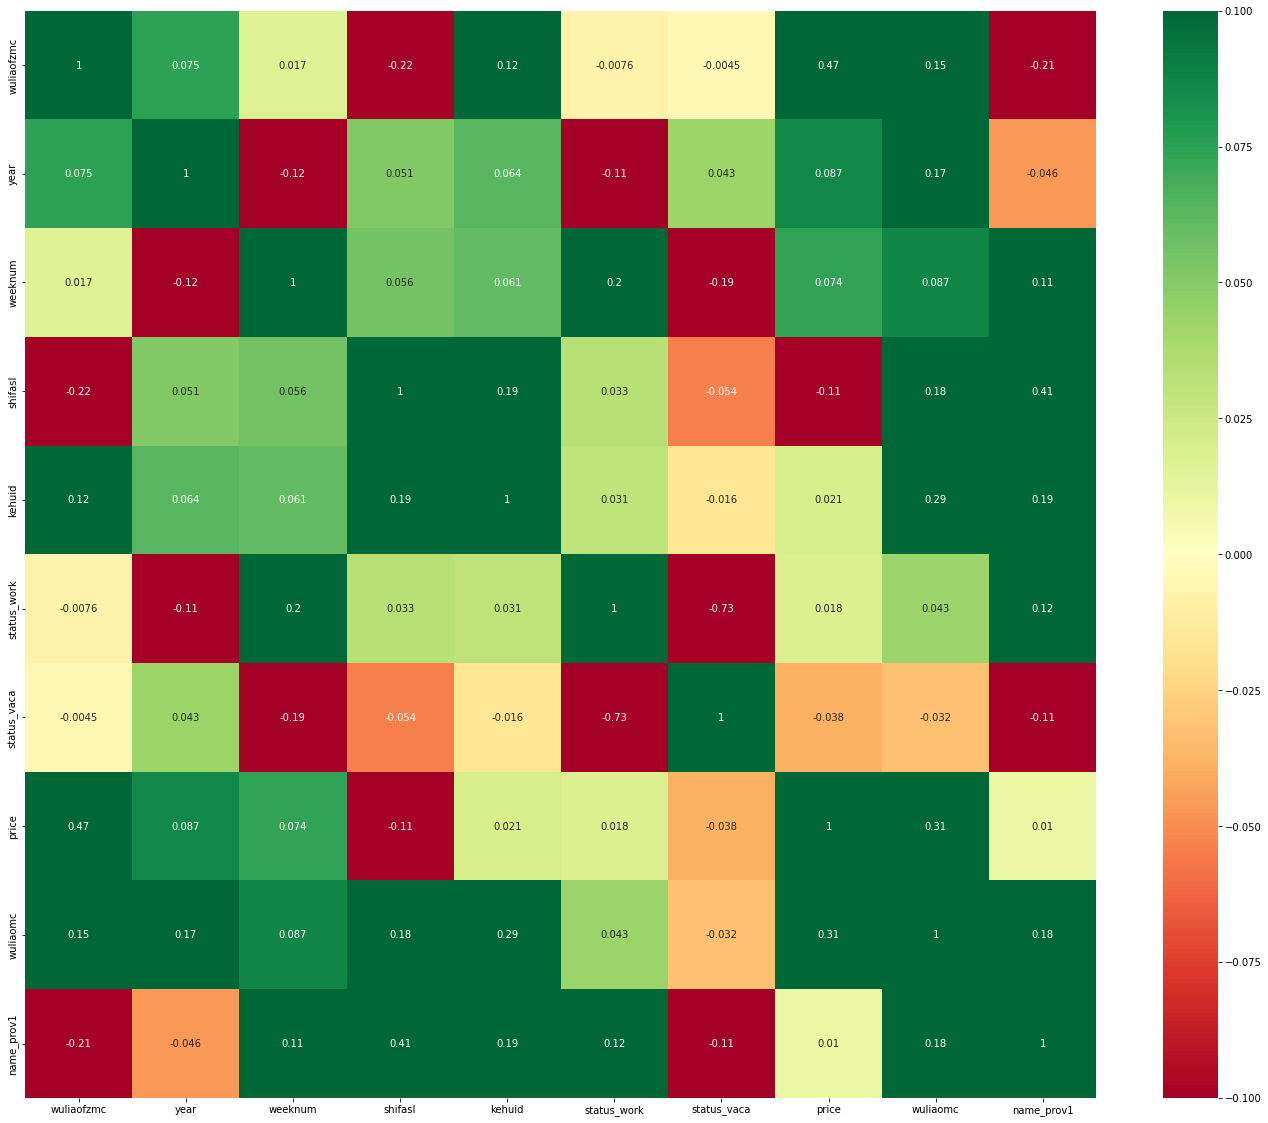

In [ ]:
#删掉训练和测试数据集中不需要的特征
df_train = df_qd.drop(['index','yweek'],axis=1)

plt.subplots(figsize=(24,20))
sns.heatmap(df_train.corr(),cmap='RdYlGn',annot=True,vmin=-0.1,vmax=0.1,center=0)

In [ ]:
df_train

wuliaofzmc  year  weeknum  shifasl  kehuid  status_work  status_vaca  \
0              1  2019        3    640.0     2.0            3            2   
1              2  2019        3    804.0     5.0            3            2   
2              3  2019        3    760.0     6.0            3            2   
3              5  2019        3    479.0     5.0            3            2   
4             13  2019        3    304.0    10.0            3            2   
...          ...   ...      ...      ...     ...          ...          ...   
6046          50  2022        2     67.0    67.0            3            2   
6047          51  2022        2      1.0     1.0            3            2   
6048          52  2022        2      7.0     7.0            3            2   
6049          53  2022        2      3.0     3.0            3            2   
6050          54  2022        2      3.0     2.0            3            2   

           price  wuliaomc  name_prov1  
0       8.550000       2.0         1.0  
1       8.115672       3.0         1.0  
2      16.626316       2.0         2.0  
3       3.800000       2.0         1.0  
4      12.000000       2.0         1.0  
...          ...       ...         ...  
6046   55.831940      14.0         1.0  
6047  111.000000       1.0         1.0  
6048  217.805714       2.0         1.0  
6049   87.586667       2.0         1.0  
6050  299.403333       2.0         1.0  

[6051 rows x 10 columns]

训练集划分

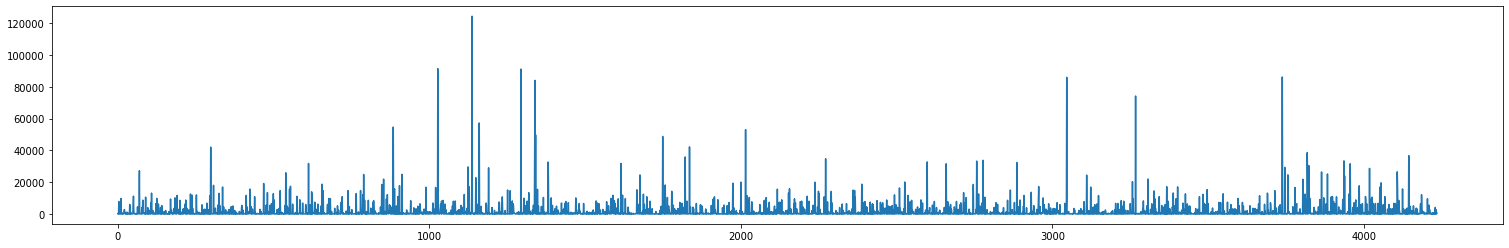

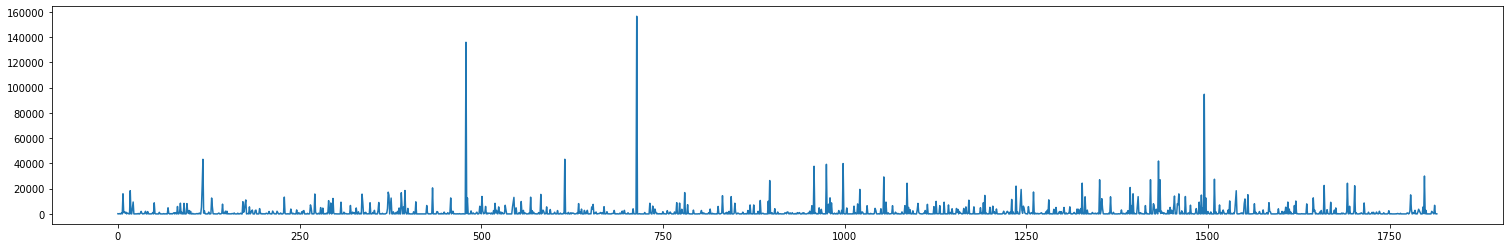

In [ ]:
# 设置数据集，切分数据，固定随机种子（random_state）时，同样的代码，得到的训练集数据相同。
x, y = df_train.drop(['shifasl'],axis=1),df_train['shifasl']
Xtrain, Xtest, ytrain, ytest = model_selection.train_test_split( x, y, test_size=0.3, random_state=42)

# 查看分布
pytrain = ytrain.reset_index(drop=True)
plt.figure(figsize=(26,4))   
plt.plot(pytrain.index,pytrain.values)

pytest = ytest.reset_index(drop=True)
plt.figure(figsize=(26,4))   
plt.plot(pytest.index,pytest.values)

定义测试集

In [ ]:
# 以数据集的未来一天开始作为预测的第一天，共预测6周
date_start = df_sales['riqi'].max()+timedelta(1)
date_end = df_sales['riqi'].max()+timedelta(30)

# 生成测试集
df_t = create_assist_date(date_start,date_end)
df_t = change(df_t)
df_t['wuliaofzmc'] = pd.Series() 

# 增加类别项
list_t = []
for i in dict_(df_qd,'wuliaofzmc')[1]:
    df_t1 = df_t.fillna(i)
    list_t.append(df_t1)
df_test = pd.concat(list_t, sort=False)

C:\Users\liujin02\AppData\Local\Temp/ipykernel_19056/3806134080.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['status'][i] = 2
C:\Users\liujin02\AppData\Local\Temp/ipykernel_19056/3806134080.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['status'][i] = 1
C:\Users\liujin02\AppData\Local\Temp/ipykernel_19056/4237481352.py:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_t['wuliaofzmc'] = pd.Series()


In [ ]:
df_test['wuliaofzmc'].replace(dict_wl,inplace=True) # 特征替换
df_test['weeknum'] = df_test['riqi'].map(lambda x: int(datetime.strptime(str(x)[:10],'%Y-%m-%d').strftime('%W'))+1)
df_test['vacation'] = df_test['weeknum'].map(lambda x:1 if x in [1,2,3,4,5,6,7,8,27,28,29,30,31,32,33,34,35] else 0)# 1为寒暑假，0为非寒暑假
df_test['status_vaca'] = df_test['status'].map(lambda x:1 if x == 1 else 0)
df_test['status_work'] = df_test['status'].map(lambda x:1 if x == 2 else 0)

table1 = df_test.groupby(['wuliaofzmc','year','weeknum']).agg({'status_work':'sum','status_vaca':'sum','vacation':'max',})# 'status_vaca':'sum',
table1.reset_index(inplace=True)

table1['yweek'] = table1['year']*100+table1['weeknum']
table1.sort_values(['yweek','wuliaofzmc'],inplace=True) # 时间升序
table1.reset_index(drop=True,inplace=True)

# 该模块采用不同时间段特征，两者可更换
# -------------------------------------------------------------------------------------------------------------------------------
# table1['year1'] = table1['year']-1
# df_qd1 = df_qd[['year','weeknum','wuliaofzmc','kehuid','price','wuliaomc','name_prov1']]
# df_test = pd.merge(table1,df_qd1,left_on=['wuliaofzmc','year1','weeknum'],right_on=['wuliaofzmc','year','weeknum'],how='left')

# #删掉训练和测试数据集中不需要的特征
# df_test = df_test.drop(['yweek','year_y','year1'],axis=1)
# df_test.rename(columns={'year_x':'year'},inplace=True)

# *******************************************************************************************************************************

table2 = df_qd.iloc[-len(table1):][['price','kehuid','name_prov1','wuliaomc']]
table2.reset_index(drop=True,inplace=True)

df_test = pd.concat([table1 ,table2 ],axis=1)
df_test = df_test.drop(['yweek'],axis=1)

# -------------------------------------------------------------------------------------------------------------------------------

df_test = df_test[Xtrain.columns] # 列标签顺序调整

模型评估

In [ ]:
model_br = BayesianRidge()  # 建立贝叶斯回归模型
model_lr = LinearRegression() # 建立普通线性回归模型
model_etc = ElasticNet() # 建立弹性网络回归模型
model_svr = SVR() # 建立支持向量回归模型
model_gbr = GradientBoostingRegressor() # 建立梯度增强回归模型
model_xgb = xgb.XGBRegressor(objective ='reg:squarederror') # XGBoost回归模型


model_names = ['BayesianRidge','LinearRegression','ElasticNet', 'SVR', 'GBR','XGBR']
model_dir = [model_br, model_lr, model_etc, model_svr, model_gbr, model_xgb]


# 交叉验证评分与模型训练

cv_score_list = [] # 交叉检验结果列表
y_train_pre = [] # 各个模型预测的y值列表
y_test_pre = [] # 创建测试集预测结果列表
n_folds = 20 # 设置交叉检验的次数


for model in model_dir:
    scores = cross_val_score(model, Xtrain, ytrain, cv = n_folds,scoring = 'r2')
    #对每个回归模型进行交叉验证,返回每次模型得分
    cv_score_list.append(scores) # 将验证结果保存在列表中
    y_train_pre.append(model.fit(Xtrain, ytrain).predict(Xtrain))
    y_test_pre.append(model.fit(Xtrain, ytrain).predict(Xtest))
    #将训练模型的预测结果保存在列表中
print(cv_score_list)
 

# 模型效果评估
n_samples, n_features = Xtrain.shape # 总训练样本量，总特征量
n_samples_test = Xtest.shape[0]
print("总训练样本：{}，总特征量：{}" .format(n_samples,n_features) )
print("总测试样本：{}" .format(n_samples_test) )


# EV: 解释回归模型的方差得分，[0,1]，接近1说明自变量越能解释因变量的方差变化
# MAE: 平均绝对误差，评估预测结果和真实数据集的接近程度的程度，越小越好
# MSE: 均方差，计算拟合数据和原始数据对应样本点的误差的平方和的均值，越小越好
# R2: 判定系数，解释回归模型的方差得分，[0,1]，接近1说明自变量越能解释因变量的方差变化。

model_metrics_name =[explained_variance_score, mean_absolute_error, mean_squared_error,r2_score]
model_metrics_list = [] # 回归评价指标列表

for i in range(len(model_dir)):
    x = [] 
    for one in model_metrics_name:  
        tmp_score = one(ytest,y_test_pre[i])  
        x.append(tmp_score) 
    model_metrics_list.append(x)  

model_metrics = pd.DataFrame(model_metrics_list,columns=['explained_variance_score','mean_absolute_error', 'mean_squared_error','r2_score'],index=model_names)
print(model_metrics)

[array([0.3680555 , 0.3556591 , 0.40591893, 0.39618272, 0.1944774 ,
       0.16314647, 0.13404304, 0.37775362, 0.2200301 , 0.30205451,
       0.32928348, 0.42425081, 0.19786842, 0.34581365, 0.19834831,
       0.20865301, 0.49709939, 0.17994492, 0.38461731, 0.40611862]), array([0.36556815, 0.35514983, 0.40643346, 0.39350437, 0.19485926,
       0.16382079, 0.13422535, 0.37556677, 0.21863372, 0.30163433,
       0.3281889 , 0.42137419, 0.1957078 , 0.34516104, 0.19942987,
       0.20871193, 0.49295862, 0.17996253, 0.38616444, 0.40643285]), array([0.37862243, 0.33962652, 0.37071186, 0.40863006, 0.17744097,
       0.14301327, 0.1242774 , 0.39539836, 0.2345668 , 0.2874921 ,
       0.32527691, 0.44757757, 0.2083886 , 0.33819484, 0.16478222,
       0.1995003 , 0.53521926, 0.17025253, 0.33895213, 0.37857829]), array([-0.16388666, -0.10377198, -0.13894282, -0.13525307, -0.0697224 ,
       -0.05368013, -0.0627802 , -0.14129205, -0.08046608, -0.09083413,
       -0.14304421, -0.19354826, -0.11619147,

In [ ]:
# loss：损失函数，ls（Least squares），默认方法，是基于最小二乘法方法的基本方法，也是普通线性回归的基本方法；
# lad（Least absolute deviation）是用于回归的鲁棒损失函数，它可以降低异常值和数据噪音对回归模型的影响；
# huber是一个结合ls和lad的损失函数，它使用alpha来控制对异常值的灵敏度；
# quantile是分位数回归的损失函数，使用alpha来指定分位数用于预测间隔。
# min_samples_leaf：作为叶子节点的最小样本数。如果设置为数字，那么将指定对应数量的样本，如果设置为浮点数，则指定为总样本量的百分比。
# alpha：用于huber或quantile的调节参数。

parameters = {'loss': ['ls','lad','huber','quantile'],
               'min_samples_leaf': [5,6,7,8],
               
               'alpha': [0.1,0.3,0.6,0.9]}# 定义要优化的参数信息


model_gs = GridSearchCV(estimator=model_gbr, param_grid=parameters, cv=20)# 建立交叉检验模型对象
model_gs = model_gs.fit(Xtrain, ytrain)# 训练交叉检验模型
print('Best score is:', model_gs.best_score_)# 获得交叉检验模型得出的最优得分
print('Best parameter is:', model_gs.best_params_)# 获得交叉检验模型得出的最优参数
model_best = model_gs.best_estimator_  # 获得交叉检验模型得出的最优模型对象
model_best.fit(Xtrain, ytrain)  # 训练最优模型
model_best.fit(Xtest, ytest)  # 训练最优模型

D:\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
D:\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
D:\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
D:\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
D:\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
D:\lib\site-packages

Best score is: 0.7527427404467353
Best parameter is: {'alpha': 0.1, 'loss': 'ls', 'min_samples_leaf': 7}


D:\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
D:\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(


GradientBoostingRegressor(alpha=0.1, loss='ls', min_samples_leaf=7)

Mean Ratio of predition and real sales data is 11.405250775220948:store all
Mean Ratio of predition and real sales data is 61.95756085547354:wuliaofzmc 1
Mean Ratio of predition and real sales data is 76.06536362094317:wuliaofzmc 2
Mean Ratio of predition and real sales data is 24.12616713677618:wuliaofzmc 3
Mean Ratio of predition and real sales data is -7.237856847359466:wuliaofzmc 5
Mean Ratio of predition and real sales data is 103.5843099871437:wuliaofzmc 13
Mean Ratio of predition and real sales data is -10.652292806978666:wuliaofzmc 14
Mean Ratio of predition and real sales data is -21.435086776771204:wuliaofzmc 15
Mean Ratio of predition and real sales data is -17.838475922454844:wuliaofzmc 17
Mean Ratio of predition and real sales data is -16.06141870762987:wuliaofzmc 29
Mean Ratio of predition and real sales data is 90.60032829570044:wuliaofzmc 31


D:\lib\site-packages\pandas\plotting\_matplotlib\core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Mean Ratio of predition and real sales data is -9.786894656042293:wuliaofzmc 34
Mean Ratio of predition and real sales data is -7.587458722726002:wuliaofzmc 37
Mean Ratio of predition and real sales data is -15.305577795359177:wuliaofzmc 44
Mean Ratio of predition and real sales data is 232.53919363428213:wuliaofzmc 0
Mean Ratio of predition and real sales data is 0.33448063705305553:wuliaofzmc 7
Mean Ratio of predition and real sales data is -11.435012808271896:wuliaofzmc 16
Mean Ratio of predition and real sales data is -13.362515422138785:wuliaofzmc 26
Mean Ratio of predition and real sales data is -12.723293598395092:wuliaofzmc 43
Mean Ratio of predition and real sales data is -14.229787648418393:wuliaofzmc 32
Mean Ratio of predition and real sales data is -7.019578245771292:wuliaofzmc 45
Mean Ratio of predition and real sales data is -115.46884183950823:wuliaofzmc 40
Mean Ratio of predition and real sales data is -5.84060854104637:wuliaofzmc 47
Mean Ratio of predition and real sal

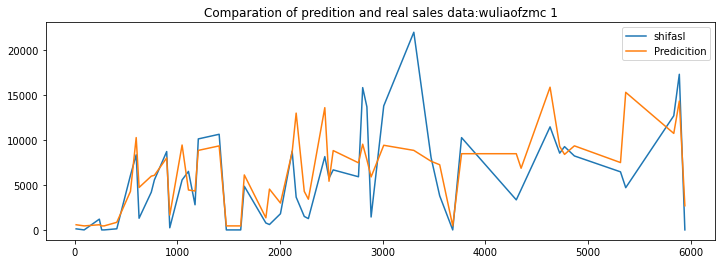

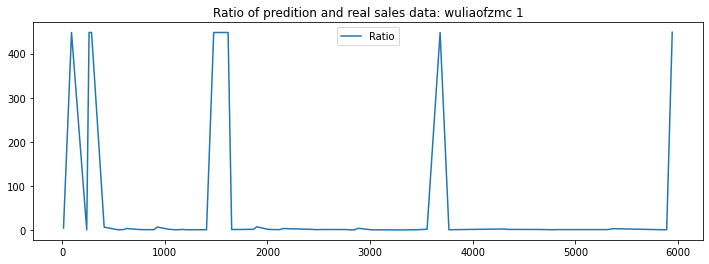

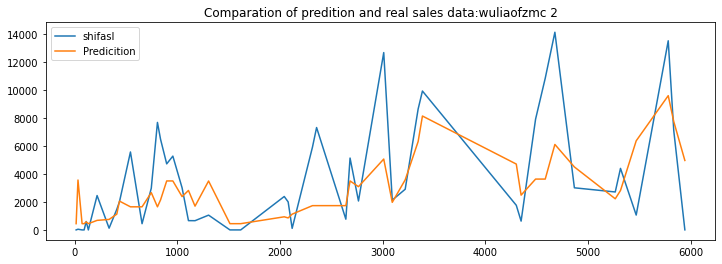

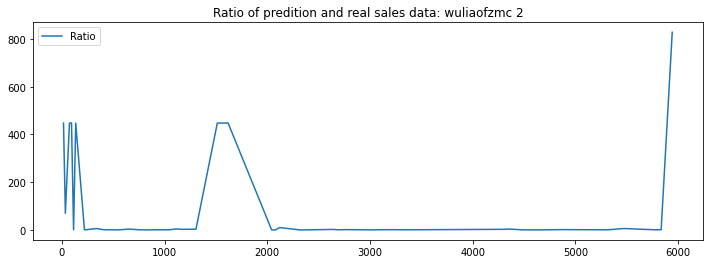

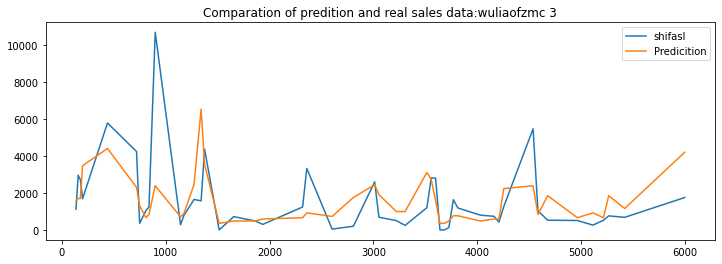

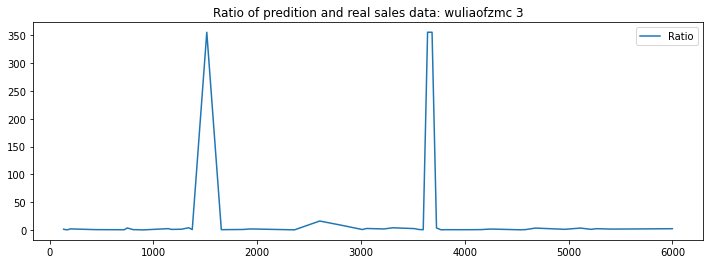

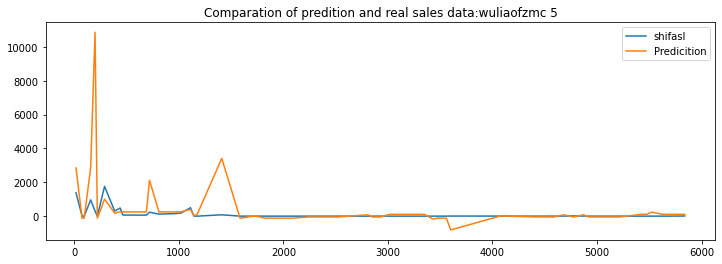

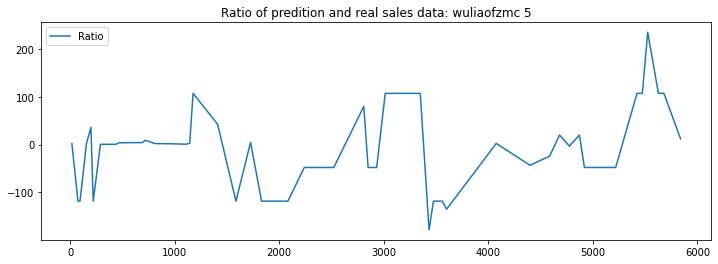

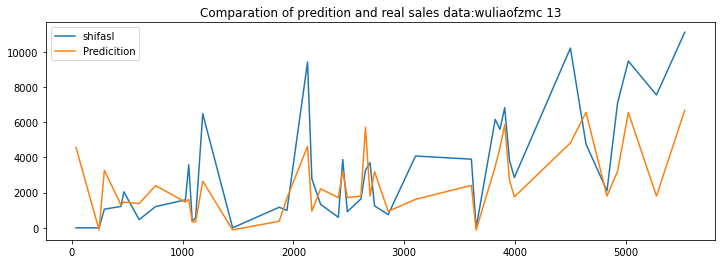

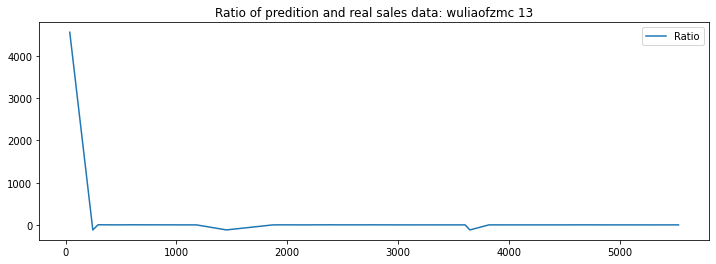

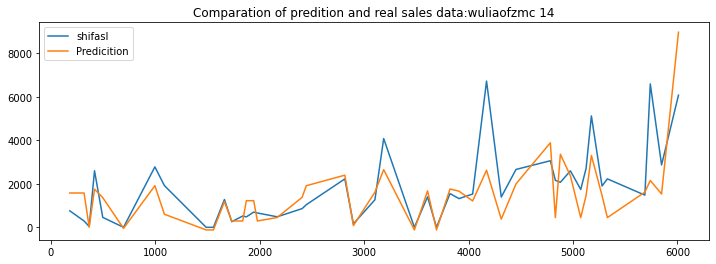

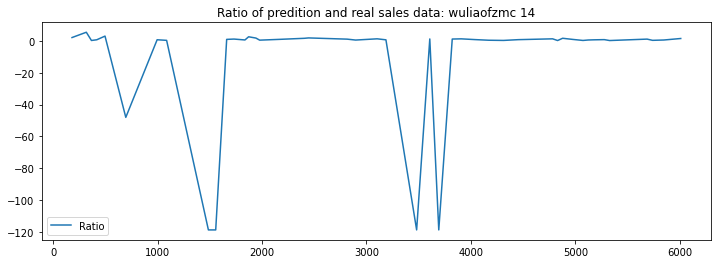

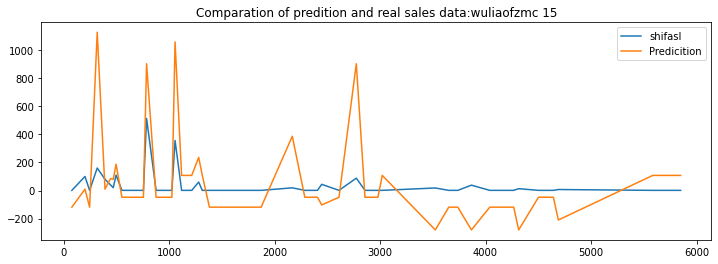

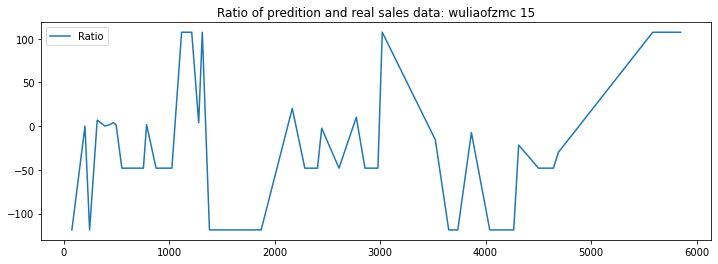

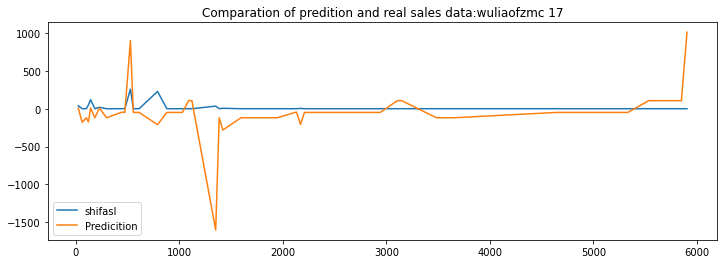

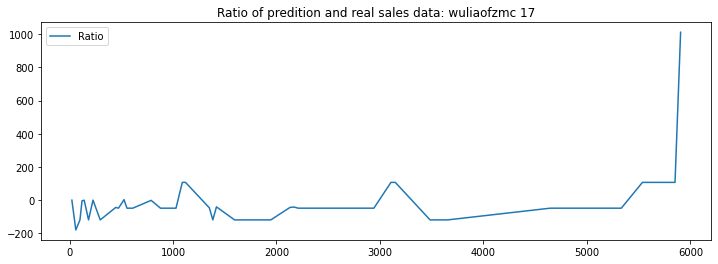

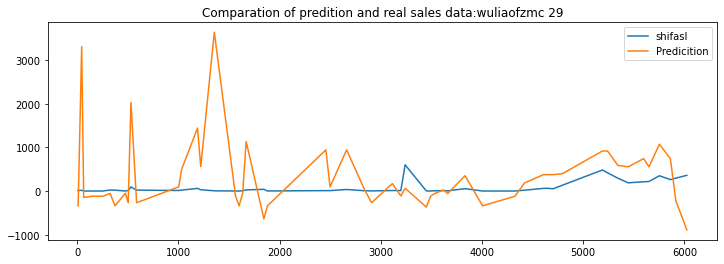

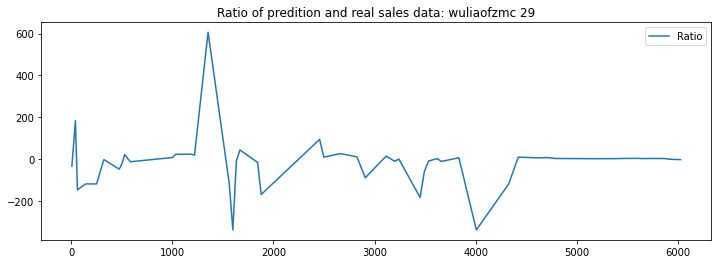

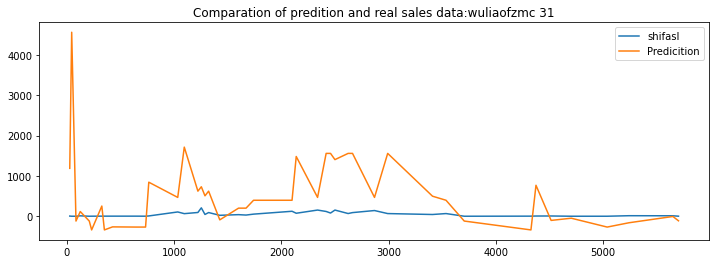

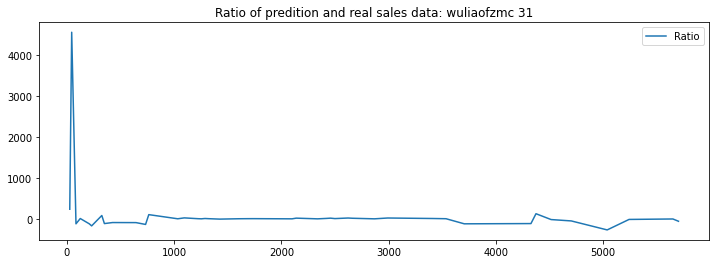

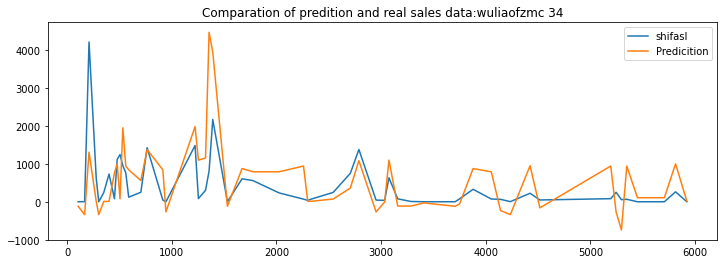

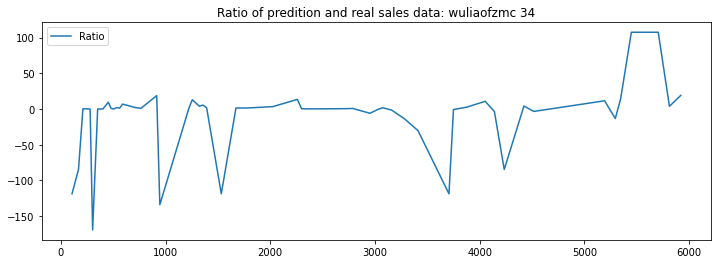

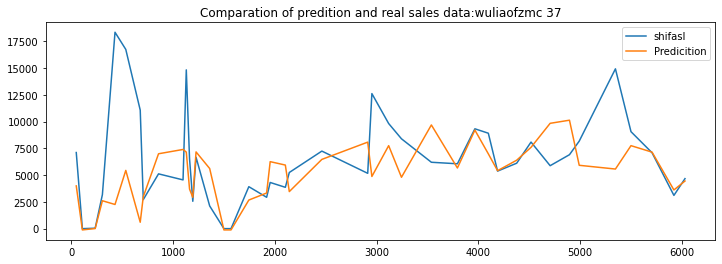

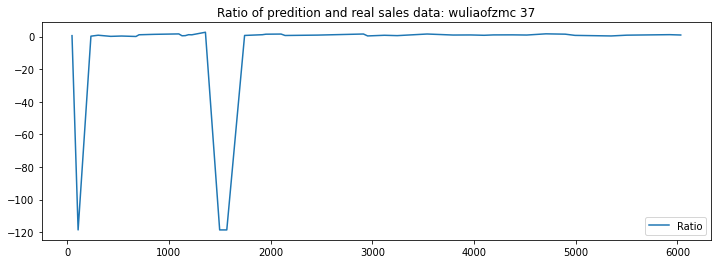

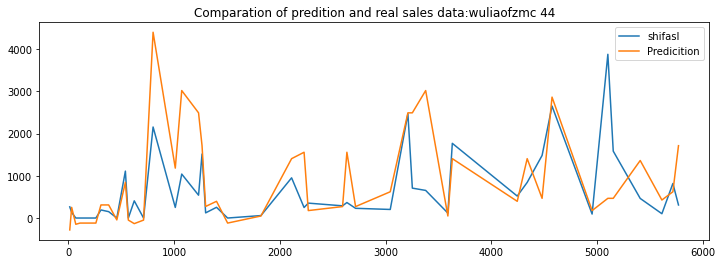

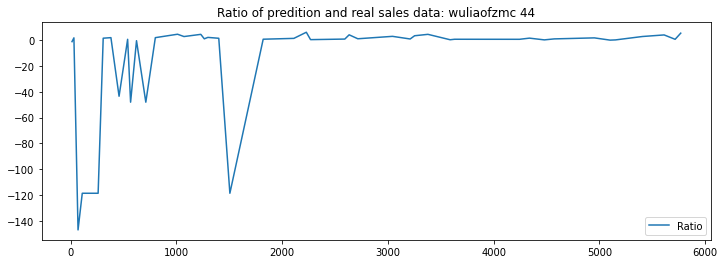

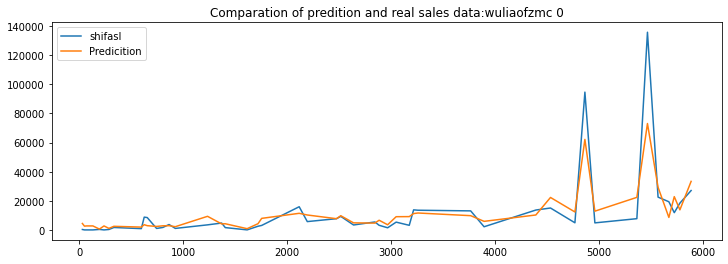

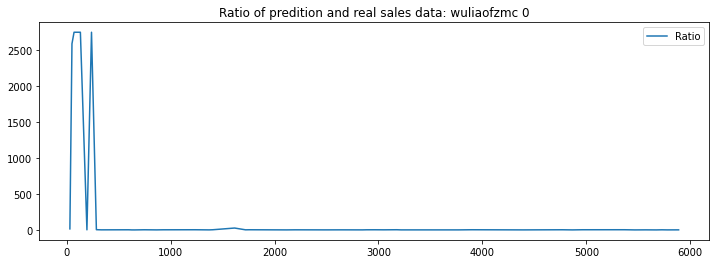

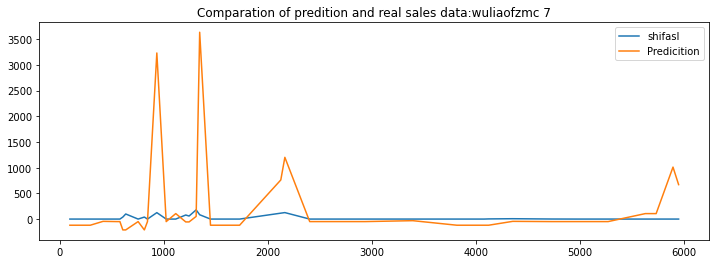

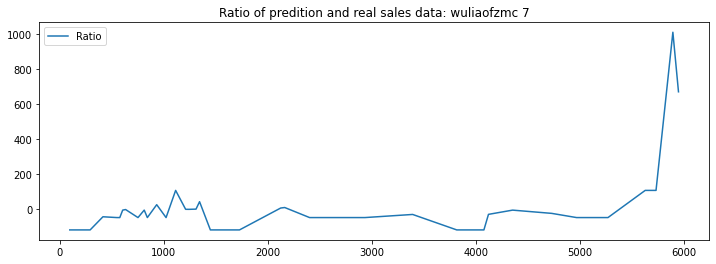

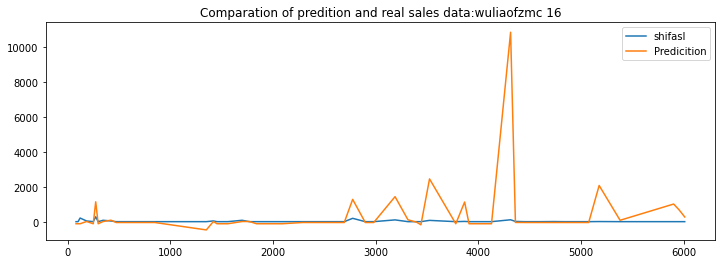

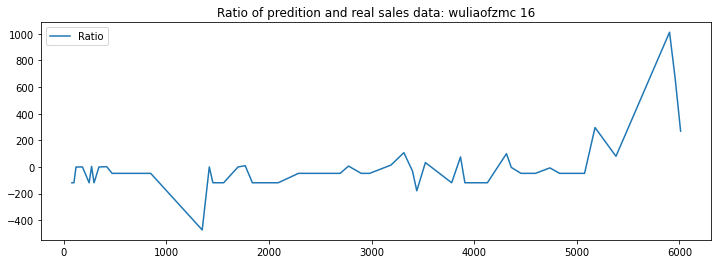

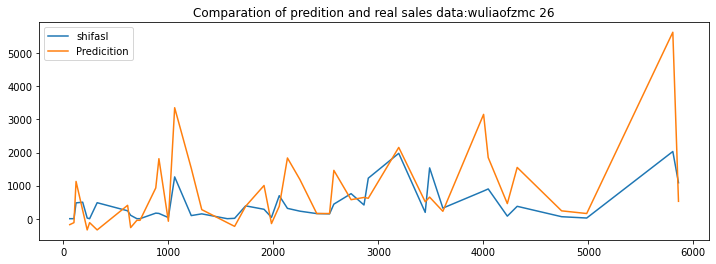

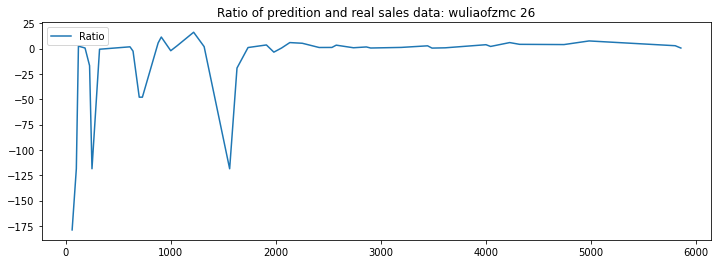

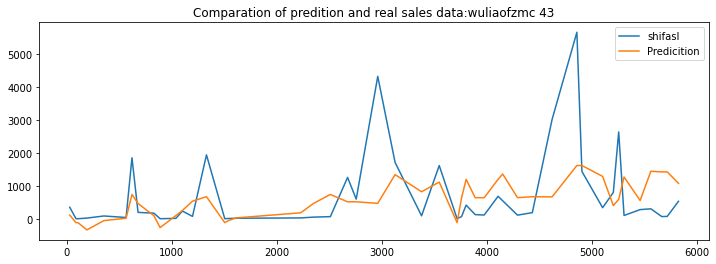

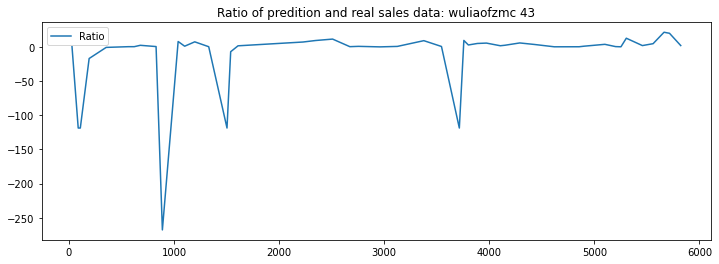

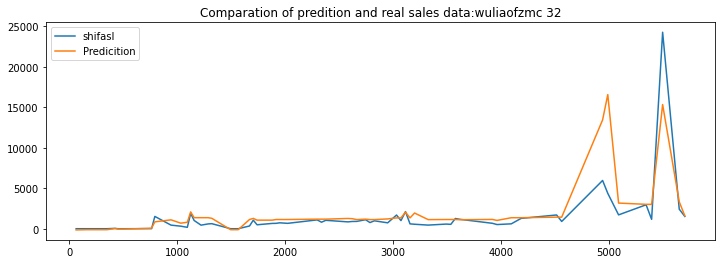

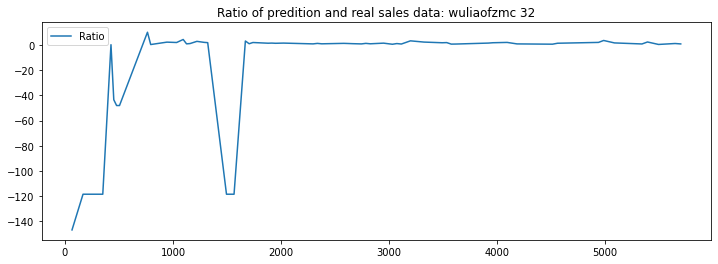

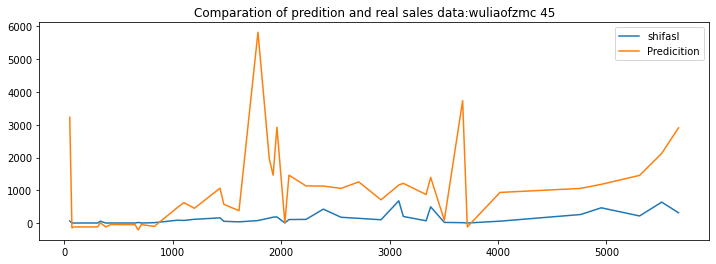

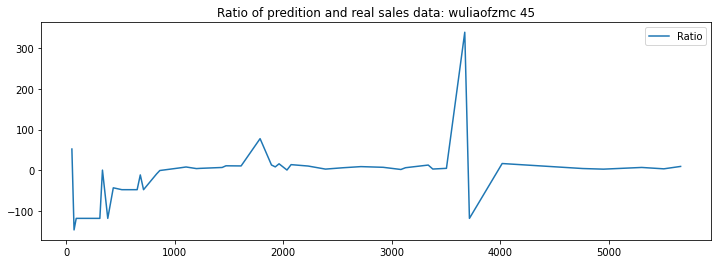

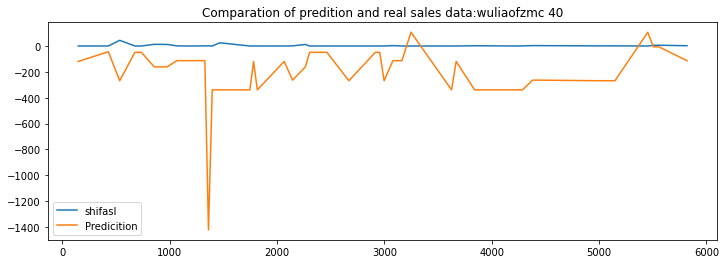

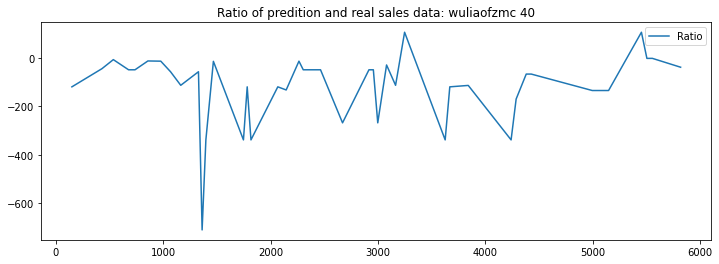

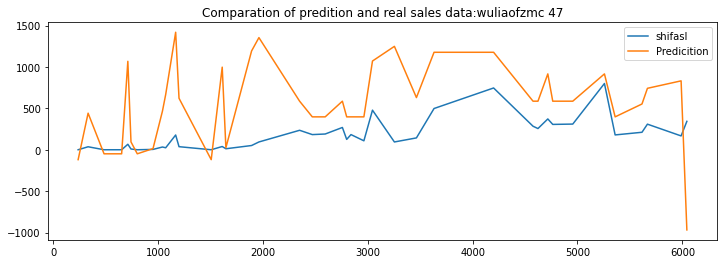

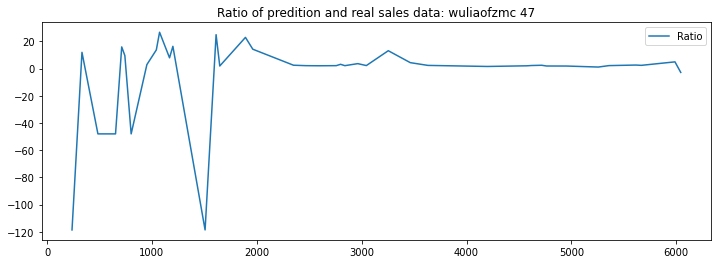

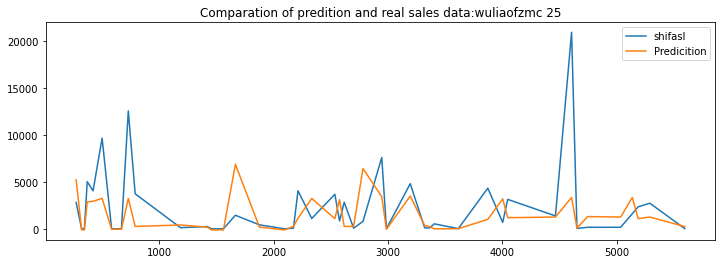

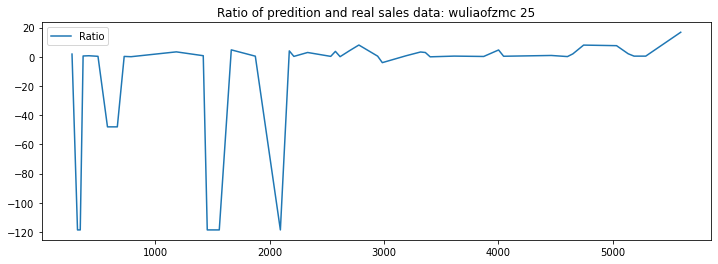

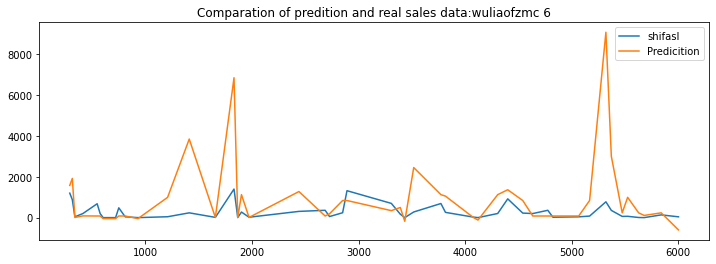

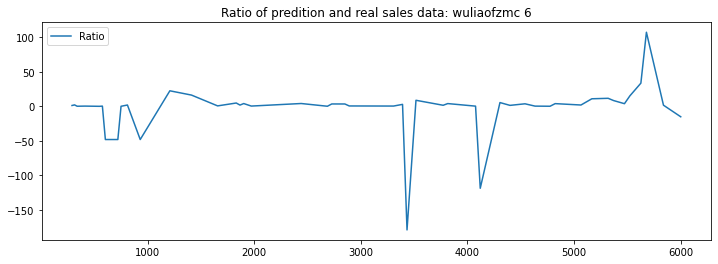

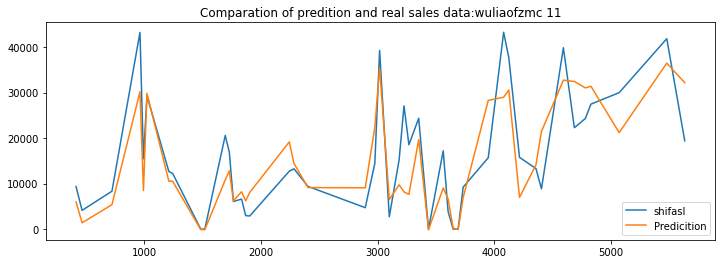

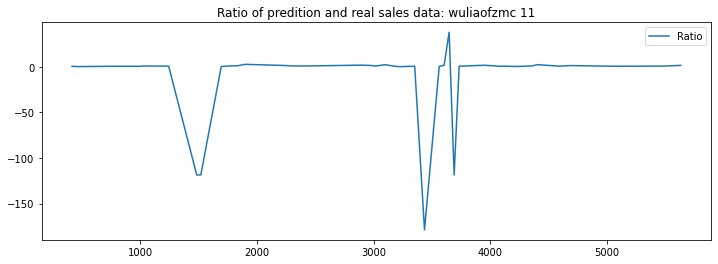

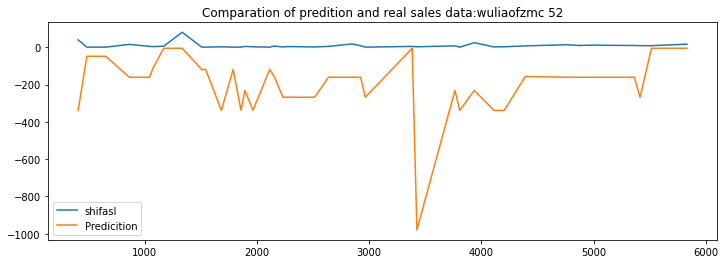

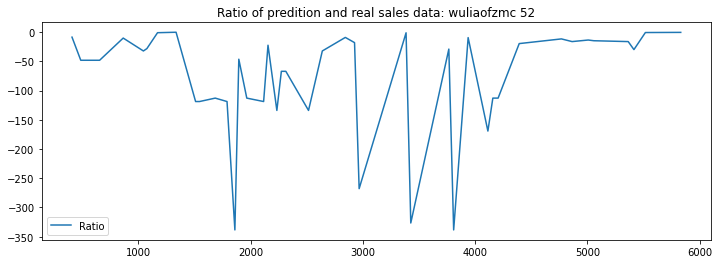

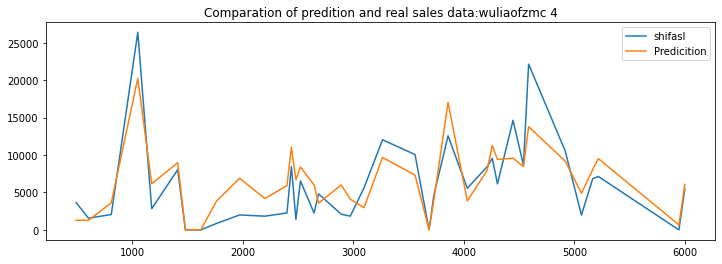

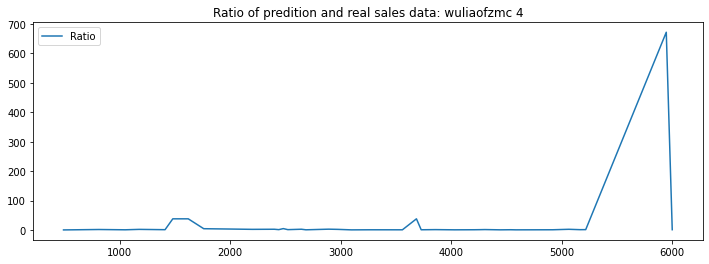

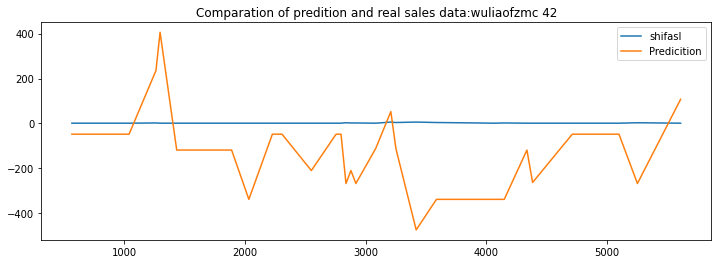

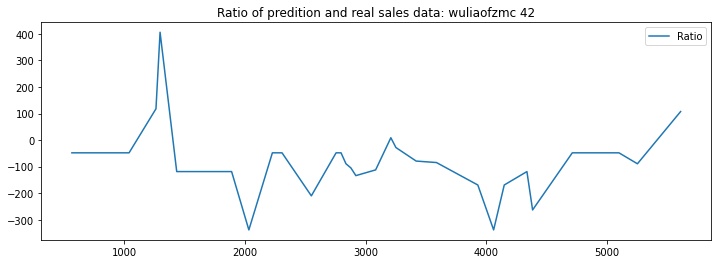

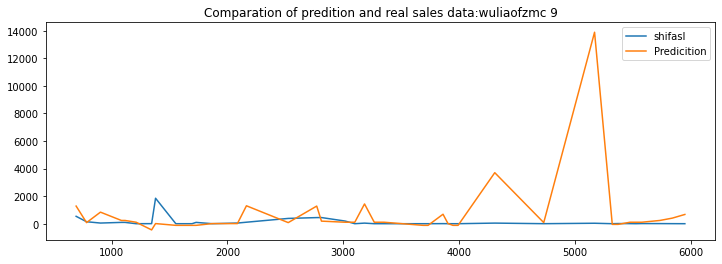

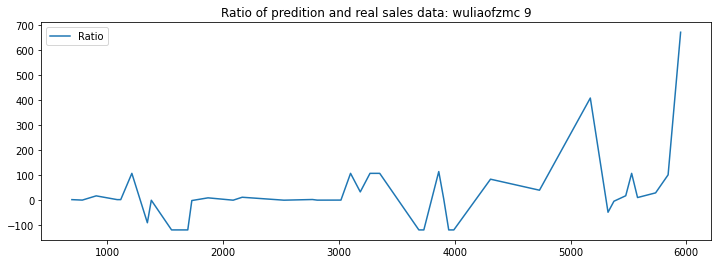

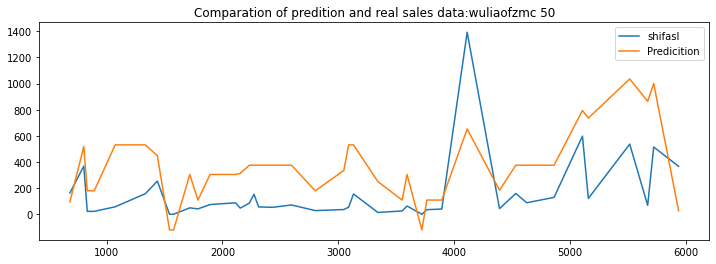

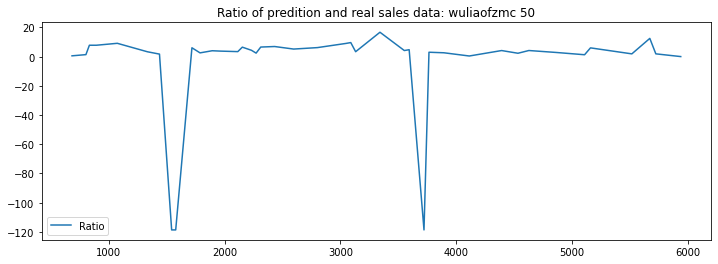

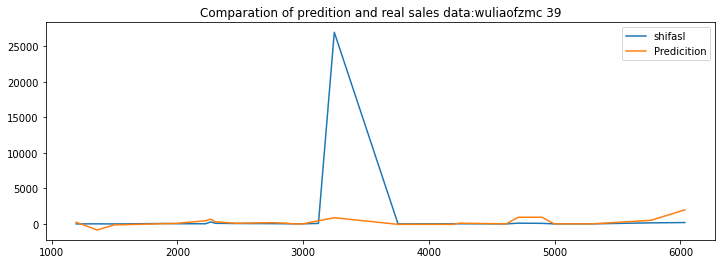

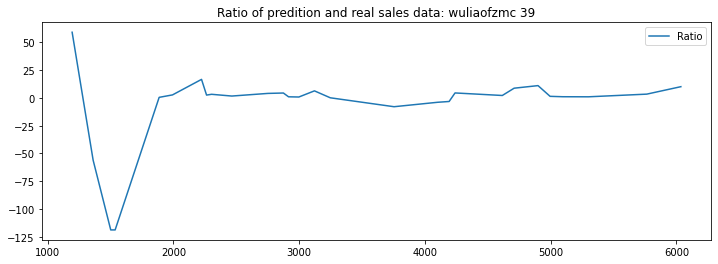

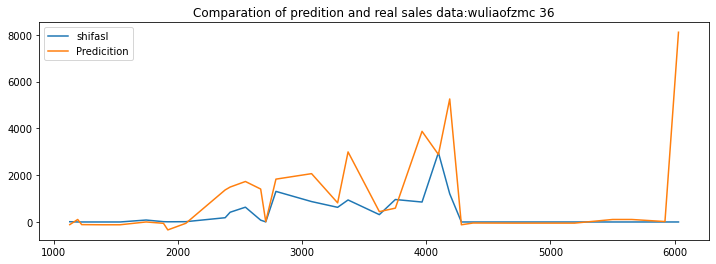

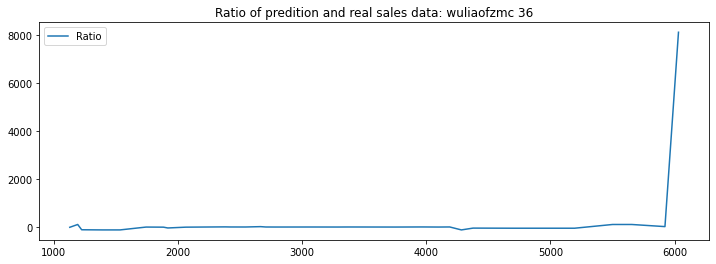

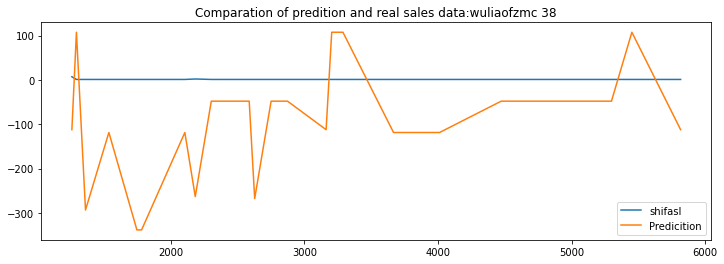

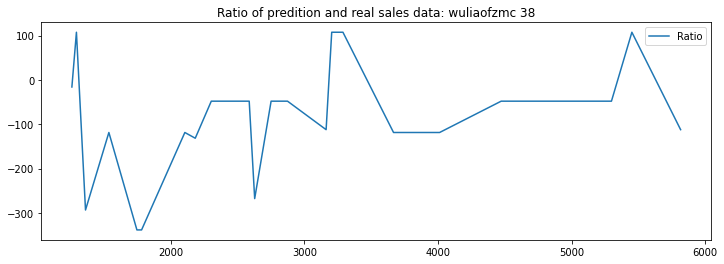

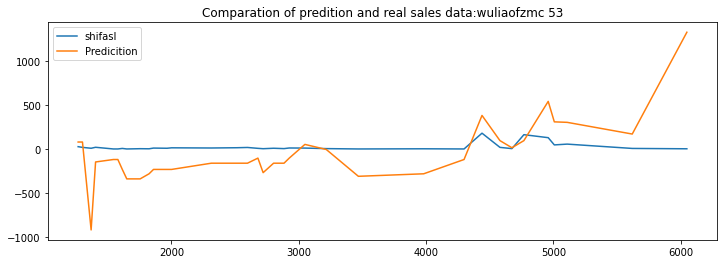

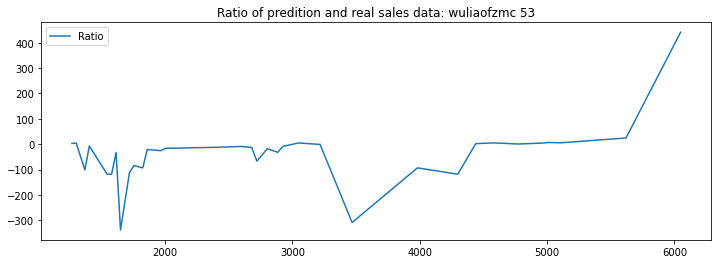

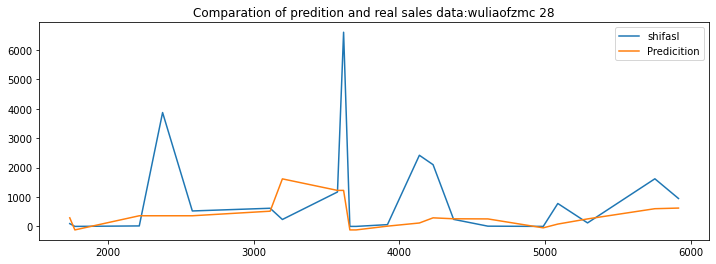

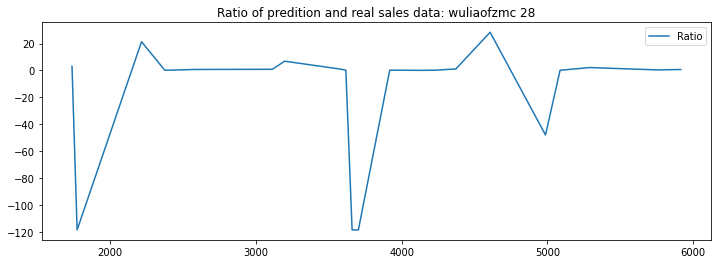

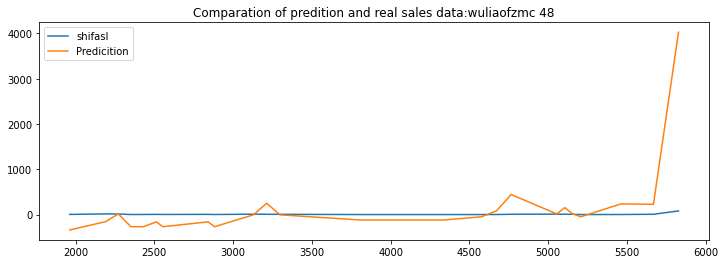

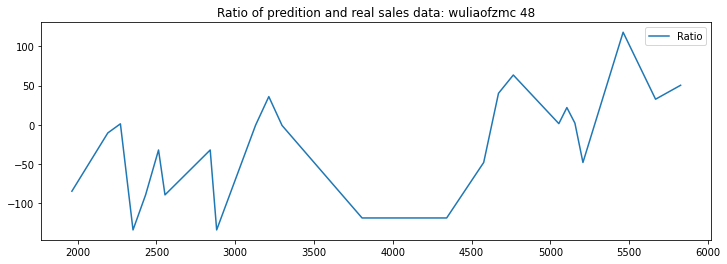

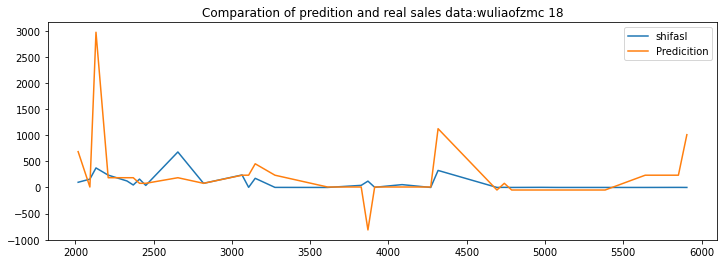

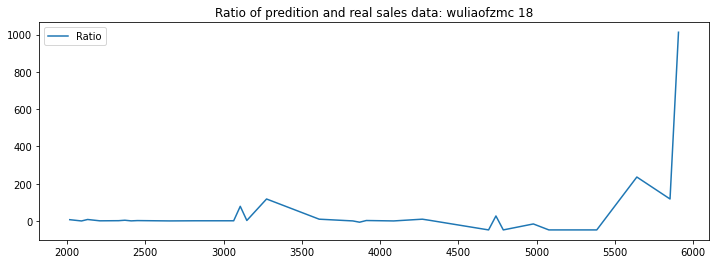

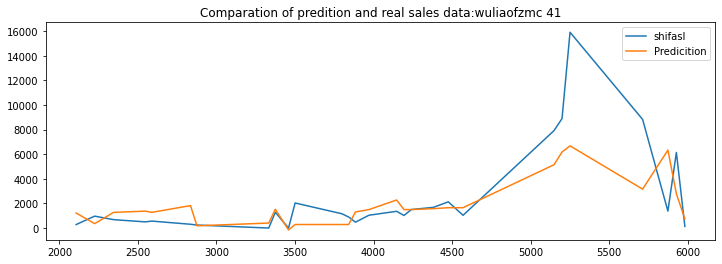

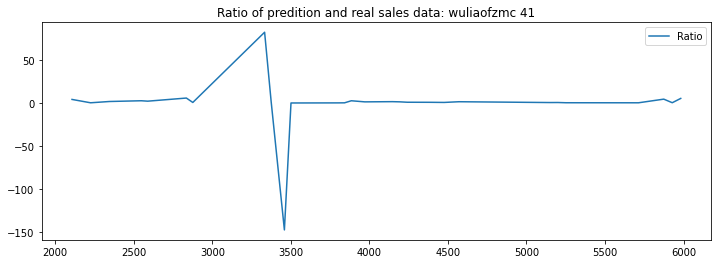

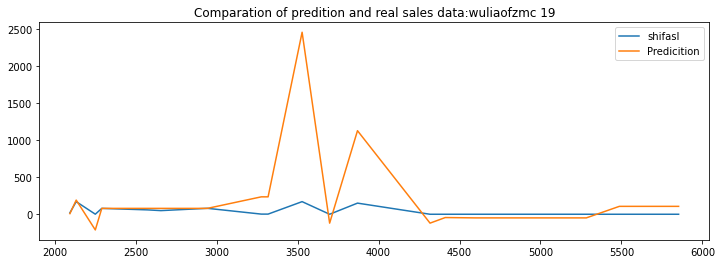

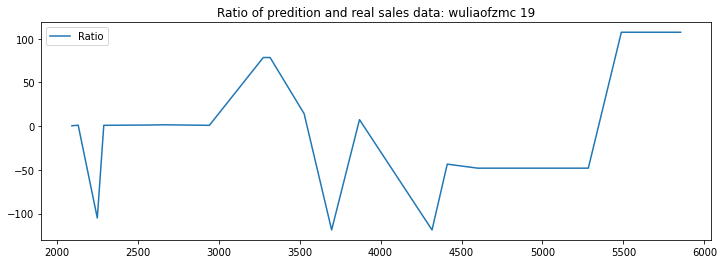

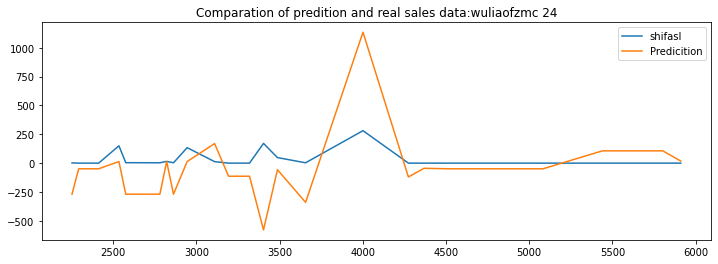

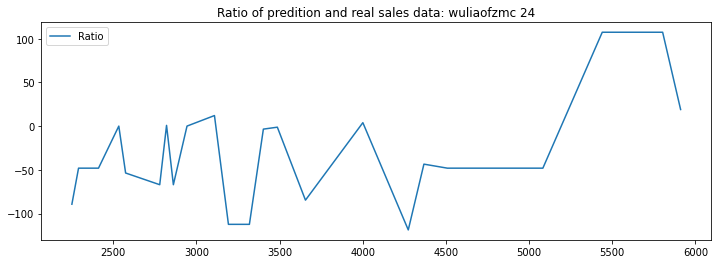

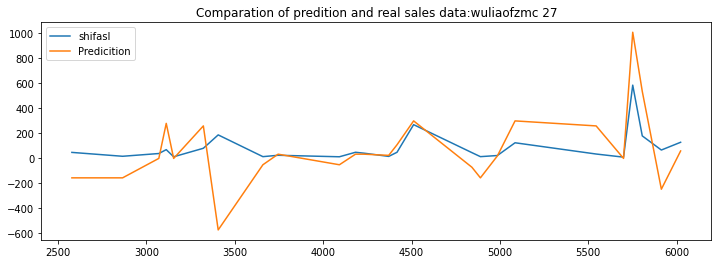

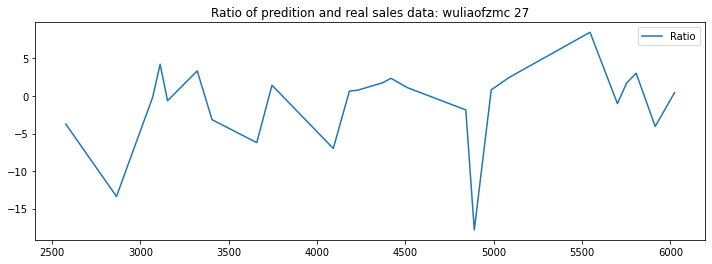

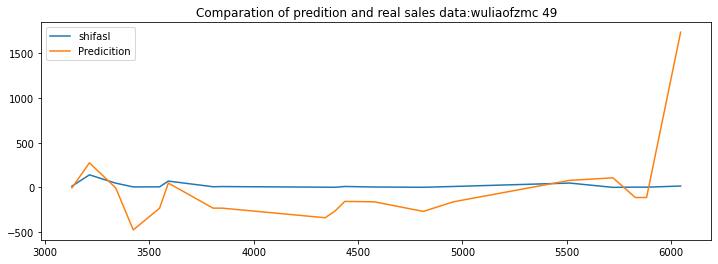

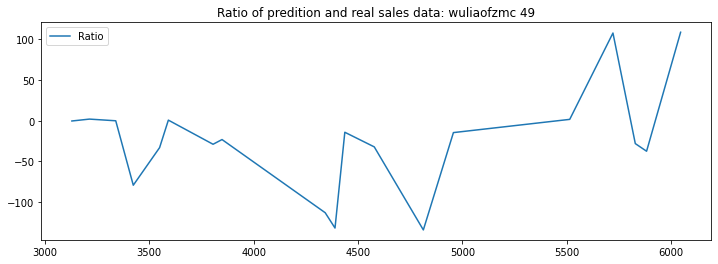

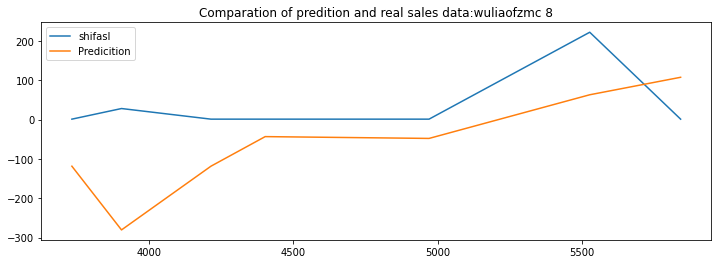

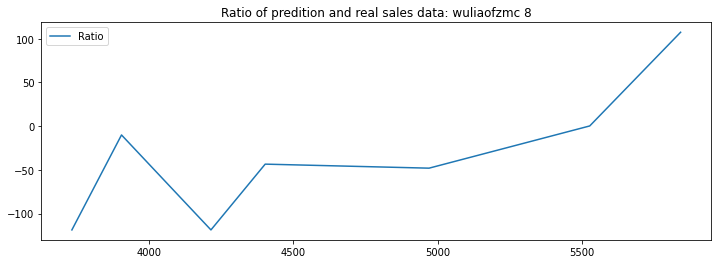

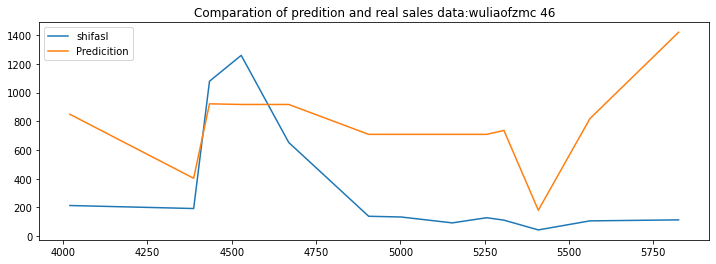

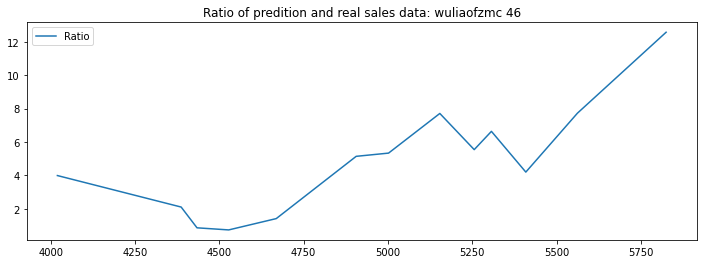

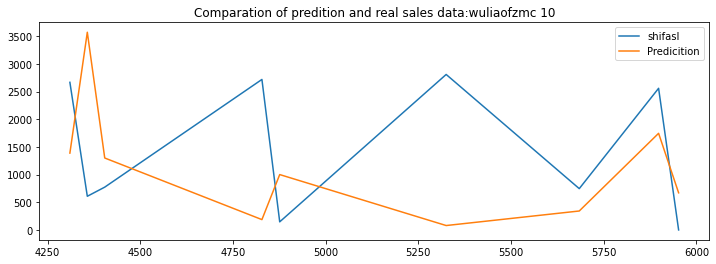

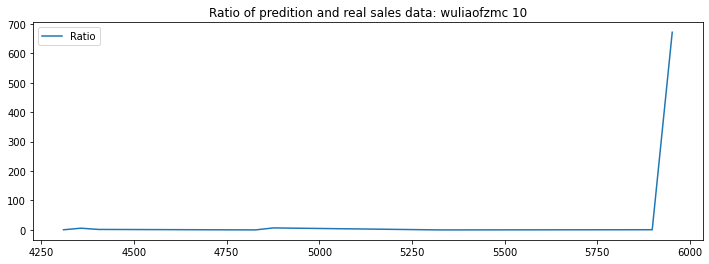

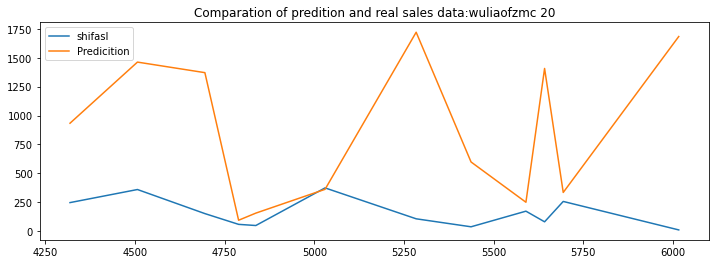

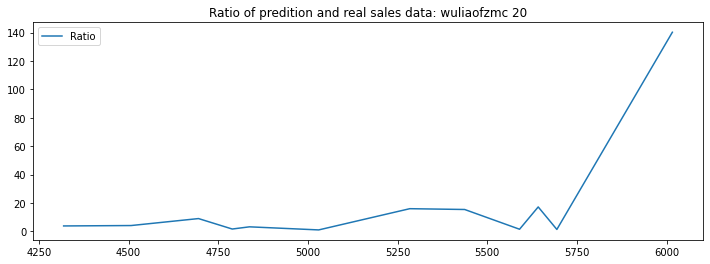

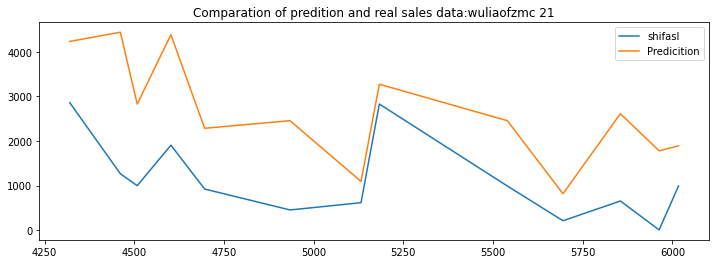

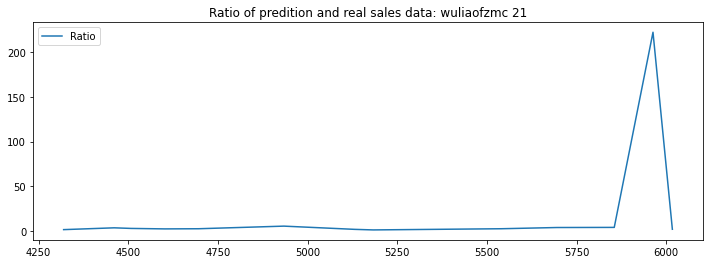

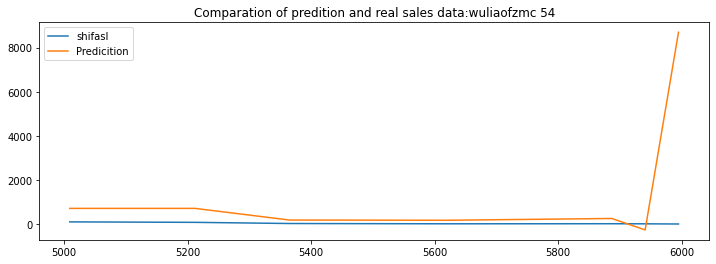

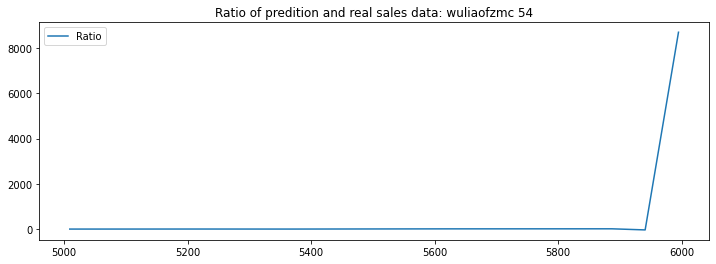

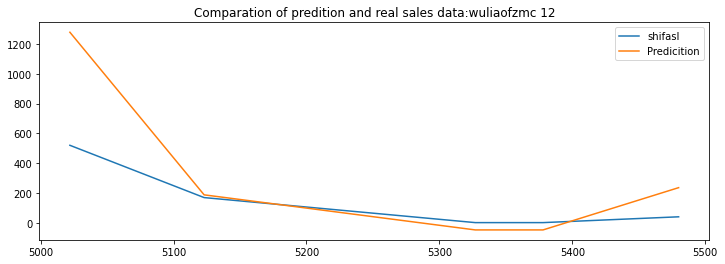

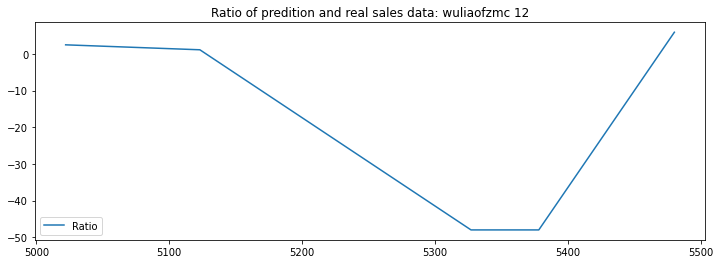

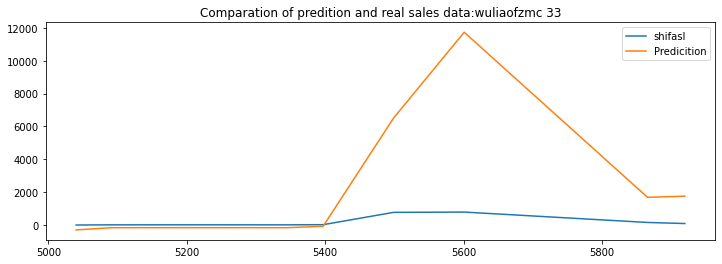

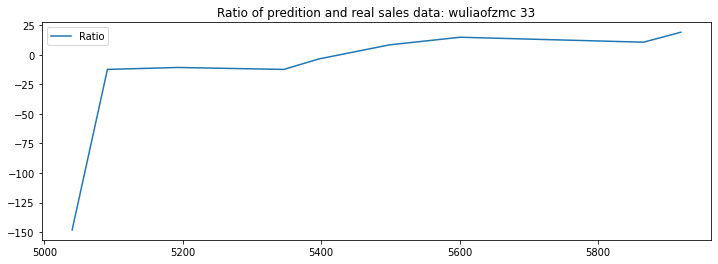

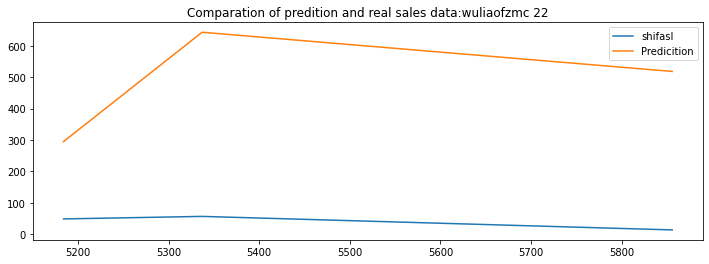

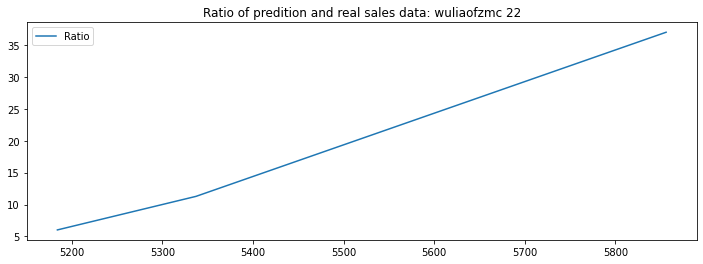

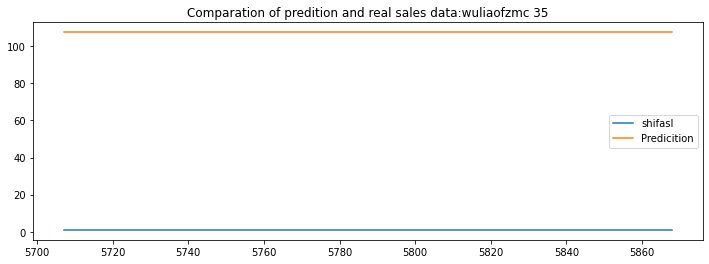

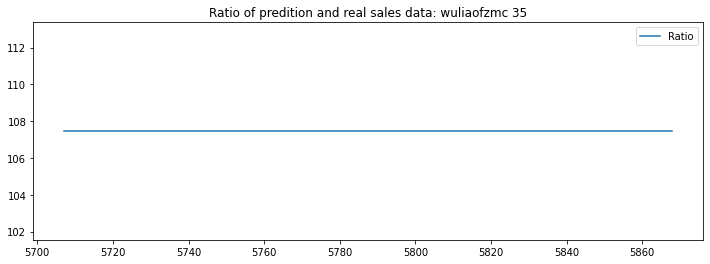

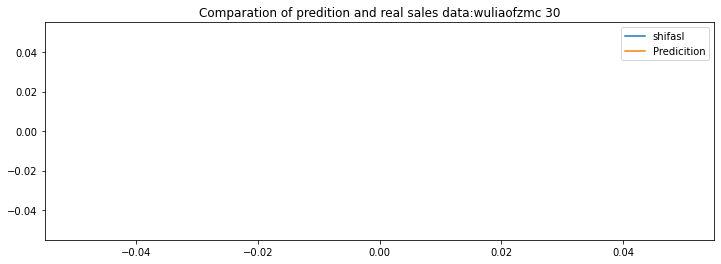

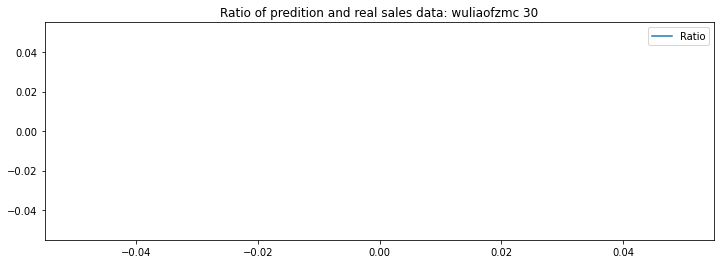

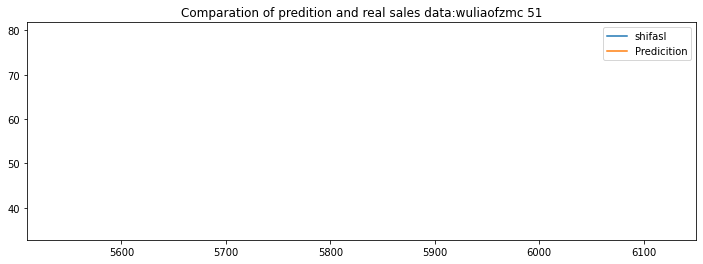

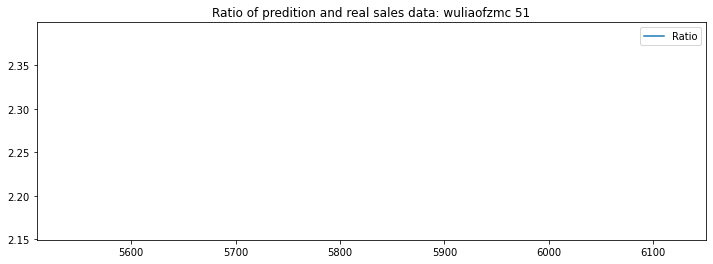

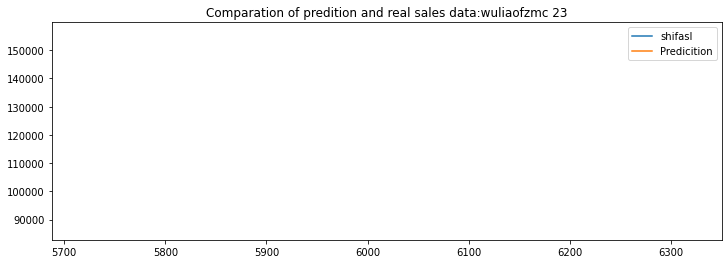

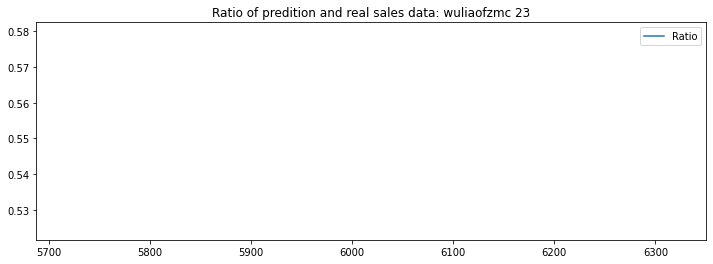

In [ ]:
#构建保留数据集预测结果
Xtest.sort_index(inplace=True)
ytest.sort_index(inplace=True)
res=pd.DataFrame(data=ytest)
res['Predicition'] = model_best.predict(Xtest)
res=pd.merge(Xtest,res,left_index=True,right_index=True)
res['Ratio']=res['Predicition']/res['shifasl']

#分析保留数据集中任意三个店铺的预测结果
col_1=['shifasl','Predicition']
col_2=['Ratio']

print('Mean Ratio of predition and real sales data is {}:store all'.format(res['Ratio'].mean()))

L=dict_(df_qd,'wuliaofzmc')[1]
for i in L:
    s1=pd.DataFrame(res[res['wuliaofzmc']==i],columns=col_1)
    s2=pd.DataFrame(res[res['wuliaofzmc']==i],columns=col_2)
    s1.plot(title='Comparation of predition and real sales data:wuliaofzmc {}'.format(i),figsize=(12,4))
    s2.plot(title='Ratio of predition and real sales data: wuliaofzmc {}'.format(i),figsize=(12,4))
    print('Mean Ratio of predition and real sales data is {}:wuliaofzmc {}'.format(s2['Ratio'].mean(),i))

模型构建

In [ ]:
df_test['Predicition'] = model_best.predict(df_test)
res['wuliaofzmc'] = res['wuliaofzmc'].map(lambda x:getDictKey(dict_wl,x,0))
df_test['wuliaofzmc'] = df_test['wuliaofzmc'].map(lambda x:getDictKey(dict_wl,x,0))

In [ ]:
res.to_excel(r'C:\Users\liujin02\Desktop\BI建设\API_BI\forecast_sales\result\val_sales.xlsx')
df_test.to_excel(r'C:\Users\liujin02\Desktop\BI建设\API_BI\forecast_sales\result\forecast_sales.xlsx')

# *****************************************写入数据库*******************************************#
df_test.to_sql('bi_forecastsales_fz', engine1, schema='bi', if_exists='replace', index=False)
engine.dispose()
engine1.dispose()

df_test.to_sql(name='bi_forecastsales_fz', con=conn, if_exists='replace', index=False)
conn.dispose() 